Load all the modules


In [1]:
import os

import torch
import torchaudio
import torch.nn as nn
from torch.utils import data

import ast
import librosa
import pandas as pd
import numpy as np

import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

Function to load the FMA Small files from where we can the file ids.

In [ ]:
def load_fma_csv(filepath):
    """
    Loads the CSV data
    https://github.com/mdeff/fma/blob/master/utils.py a part of the 'load' function
    """
    tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

    COLUMNS = [
        ("track", "tags"),
        ("album", "tags"),
        ("artist", "tags"),
        ("track", "genres"),
        ("track", "genres_all"),
    ]
    for column in COLUMNS:
        tracks[column] = tracks[column].map(ast.literal_eval)

    COLUMNS = [
        ("track", "date_created"),
        ("track", "date_recorded"),
        ("album", "date_created"),
        ("album", "date_released"),
        ("artist", "date_created"),
        ("artist", "active_year_begin"),
        ("artist", "active_year_end"),
    ]
    for column in COLUMNS:
        tracks[column] = pd.to_datetime(tracks[column])

    SUBSETS = ("small", "medium", "large")
    try:
        tracks["set", "subset"] = tracks["set", "subset"].astype(
            "category", categories=SUBSETS, ordered=True
        )
    except (ValueError, TypeError):
        # the categories and ordered arguments were removed in pandas 0.25
        tracks["set", "subset"] = tracks["set", "subset"].astype(
            pd.CategoricalDtype(categories=SUBSETS, ordered=True)
        )

    COLUMNS = [
        ("track", "genre_top"),
        ("track", "license"),
        ("album", "type"),
        ("album", "information"),
        ("artist", "bio"),
    ]
    for column in COLUMNS:
        tracks[column] = tracks[column].astype("category")

    return tracks

Load the stuff

In [ ]:
tracks = load_fma_csv("fma_metadata/tracks.csv")

Select only the small dataset data

In [ ]:
small = tracks["set", "subset"] <= "small"

train = tracks["set", "split"] == "training"
val = tracks["set", "split"] == "validation"
test = tracks["set", "split"] == "test"

y_train = tracks.loc[small & train, ("track", "genre_top")]
y_val = tracks.loc[small & val, ("track", "genre_top")]
y_test = tracks.loc[small & test, ("track", "genre_top")]

print(
    "{} training examples, {} validation examples, {} testing examples".format(
        y_train.size, y_val.size, y_test.size
    )
)

6400 training examples, 800 validation examples, 800 testing examples


One-hot encode all the genre labels

In [ ]:
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.fit_transform(y_test)

print(np.unique(y_train).size)
print(np.unique(y_val).size)
print(np.unique(y_test).size)

8
8
8


Lets load all the waveforms!

In [ ]:
# Get all the files

train &= small
tmp = train.values
tmpi = train.index.values
train_files = [tmpi[x] for x in range(len(tmp)) if tmp[x]]

val &= small
tmp = val.values
tmpi = val.index.values
val_files = [tmpi[x] for x in range(len(tmp)) if tmp[x]]

test &= small
tmp = test.values
tmpi = test.index.values
test_files = [tmpi[x] for x in range(len(tmp)) if tmp[x]]

print(len(train_files), len(val_files), len(test_files))

6400 800 800


In [ ]:
import warnings

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fs = 22050
melspec = torchaudio.transforms.MelSpectrogram(sample_rate=fs,
                                               n_fft=1024,
                                               f_min=0.0,
                                               f_max=fs / 2,
                                               n_mels=128
                                               ).to(device)

amp_to_db = torchaudio.transforms.AmplitudeToDB()

def load_specs(file_list):
    """"""
    specs = []
    chromas = []
    bad_indices = []

    for i in tqdm.tqdm(range(len(file_list)), ncols=0):
        ind = file_list[i]
        ind = int(ind)
        folder = str(ind // 1000).zfill(3)

        try:
            # Some files WILL raise an ugly warning, used to get a clean output
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')

                # Automatically resamples to 22050 and converts to mono :)
                wav, _ = librosa.load('fma_small/' + folder + '/' + str(ind).zfill(6) + '.mp3')

        except:
            # If we cannot open the file add to list for removal and move on
            bad_indices.append(i)
            continue

        try:
            # We want the files to be uniform, cut the last ~2k samples to force length, if a song doesn't have that many samples remove it from the data
            if len(wav) < 658000:
                raise

            # Lets move the tensor to cpu to not eat all the available vram
            # Also lets save the compute and save spectogram to save ram and later computing takes around ~9 GB of ram to keep all in memory
            # If you do not have this much available, load the waves when creating a batch and compute the specs in the forward of the net
            wav = wav[:658000]

            wav = torch.tensor(wav).to(device)
            specs.append(amp_to_db(melspec(wav)).to('cpu'))

        except:
            bad_indices.append(i)

    return specs, bad_indices

# Load all the specs and save to tensors
train_specs, bad_train_indices = load_specs(train_files)
train_specs = torch.stack(tuple(train_specs))

test_specs, bad_test_indices = load_specs(test_files)
test_specs = torch.stack(tuple(test_specs))

val_specs, bad_val_indices = load_specs(val_files)
val_specs = torch.stack(tuple(val_specs))

100% 6400/6400 [05:51<00:00, 18.22it/s]
100% 800/800 [00:47<00:00, 16.79it/s]
100% 800/800 [00:48<00:00, 16.53it/s]


Lets check the shape of the created spectogram tensors

In [ ]:
print(train_specs.shape)
print(test_specs.shape)
print(val_specs.shape)

torch.Size([6394, 128, 1286])
torch.Size([800, 128, 1286])
torch.Size([800, 128, 1286])


Looks good, there is supposed to be 6 tracks in FMA small that are shorter than 30 seconds. Lets remove them from the labels aswell.

In [ ]:
y_train = [y_train[x] for x in range(len(y_train)) if x not in bad_train_indices]
y_test = [y_test[x] for x in range(len(y_test)) if x not in bad_test_indices]
y_val = [y_val[x] for x in range(len(y_val)) if x not in bad_val_indices]

print(len(y_train))
print(len(y_test))
print(len(y_val))

6394
800
800


Lets convert the labels to tensors for pytorch

In [ ]:
y_train = torch.tensor(y_train, dtype = torch.long)
y_val = torch.tensor(y_val, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

Lets save the tensors so we dont need to recompute everytime we restart!

In [ ]:
torch.save(train_specs, 'CNN/train_specs.pt')
torch.save(val_specs, 'CNN/val_specs.pt')
torch.save(test_specs, 'CNN/test_specs.pt')

torch.save(y_train, 'CNN/y_train.pt')
torch.save(y_val, 'CNN/y_val.pt')
torch.save(y_test, 'CNN/y_test.pt')

Load the pre-computed data

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

specs = torch.cat((torch.load('CNN/train_specs.pt'),
                   torch.load('CNN/val_specs.pt'),
                   torch.load('CNN/test_specs.pt')
                   ))[:, :, :-6] # Remove last 6 elements to get the spectogram divisible by 8

y = torch.cat((torch.load('CNN/y_train.pt'),
               torch.load('CNN/y_val.pt'),
               torch.load('CNN/y_test.pt')
               ))

print(specs.shape)
print(y.shape)

<ipython-input-3-7f7f2cad866c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  specs = torch.cat((torch.load('/content/drive/MyDrive/Allt/Skola/Högskola KTH/Elektroteknik/

torch.Size([7994, 128, 1280])
torch.Size([7994])


Now lets build the Dataloader

In [4]:
class FMADataset(data.Dataset):
    def __init__(self, specs, labels):
        self.specs = specs
        self.labels = labels

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        return self.specs[idx], self.labels[idx]

def get_DataLoader(dataset,
                   split = 'train',
                   n_workers = 0,
                   batch_size = 32
                   ):
    shuffle = split == 'train'
    dataloader = data.DataLoader(dataset = dataset,
                                 batch_size = batch_size,
                                 shuffle = shuffle,
                                 drop_last = False,
                                 num_workers = n_workers
                                 )
    return dataloader

train_dset = FMADataset(specs, y)

train_dset, val_dset, test_dset = torch.utils.data.random_split(train_dset, [0.7, 0.2, 0.1])

train_loader = get_DataLoader(train_dset)
iter_train_loader = iter(train_loader)
train_spec, train_label = next(iter_train_loader)

test_loader = get_DataLoader(test_dset, split='test')
valid_loader = get_DataLoader(val_dset, split='val')
iter_test_loader = iter(test_loader)
test_spec, test_label = next(iter_test_loader)

print(len(train_loader), len(valid_loader), len(test_loader))
print('training data shape: %s' % str(train_spec.shape))
print('validation/test data shape: %s' % str(test_spec.shape))
print(train_label)

del train_label, test_label

175 50 25
training data shape: torch.Size([32, 128, 1280])
validation/test data shape: torch.Size([32, 128, 1280])
tensor([1, 3, 4, 0, 6, 6, 1, 2, 2, 4, 3, 2, 0, 0, 4, 6, 2, 0, 6, 3, 2, 5, 5, 7,
        2, 0, 3, 3, 6, 2, 6, 4])


Lets make 2-D Conv baseline

In [ ]:
class Conv2d_layer(nn.Module):
    def __init__(self, out_c, kernel_size, pooling, dropout=0.1):
        super(Conv2d_layer, self).__init__()
        self.layer = nn.Sequential(
            nn.LazyConv2d(out_c, kernel_size, padding = kernel_size // 2), #padding = 'valid'
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.MaxPool2d(pooling, stride = pooling),
            nn.Dropout(dropout)
        )

    def forward(self, data):
        return self.layer(data)

class CNN(nn.Module):
    def __init__(self, n_chan, kernel_size, n_genres):
        super(CNN, self).__init__()

        self.net = nn.Sequential(
            nn.BatchNorm2d(1),
            Conv2d_layer(n_chan, kernel_size, pooling=(2, 3), dropout=0.2),
            Conv2d_layer(n_chan, kernel_size, pooling=(3, 4), dropout=0.2),
            Conv2d_layer(2 * n_chan, kernel_size, pooling=(2, 5), dropout=0.2),
            Conv2d_layer(2 * n_chan, kernel_size, pooling=(3, 3), dropout=0.2),
            Conv2d_layer(4 * n_chan, kernel_size, pooling=(3, 4), dropout=0.2),
            nn.Flatten(),
            nn.LazyLinear(4 * n_chan),
            nn.BatchNorm1d(4 * n_chan),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.LazyLinear(n_genres)
        )


    def forward(self, spec):
        spec = spec.unsqueeze(1)
        return self.net(spec)

In [ ]:
cnn = CNN(n_chan = 16, kernel_size = 3, n_genres=8).to(device)

# Send a sample to the net init all the lazy layers
cnn(train_spec.to(device))

n_epochs = 150
lr = 0.001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnn.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    losses = []

    for specs, labels in tqdm.tqdm(train_loader):
        out = cnn(specs.to(device))
        loss = loss_fn(out, labels.to(device))

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch + 1, n_epochs, train_loss))

    losses = []
    y_true = []
    y_pred = []
    for specs, labels in tqdm.tqdm(valid_loader):
        with torch.no_grad():
            logits = cnn(specs.to(device))

        loss = loss_fn(logits, labels.to(device))
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    val_loss = np.mean(losses)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f, Current LR: %0.8f' % (epoch+1, n_epochs, val_loss, accuracy, scheduler.get_last_lr()[-1]))

    if np.argmin(val_losses) == epoch:
        print('New best model found!')
        torch.save(cnn.state_dict(), 'best_model_lin.ckpt')

torch.save(cnn.state_dict(), 'final_model_lin.ckpt')

100%|██████████| 88/88 [00:16<00:00,  5.30it/s]


Epoch: [1/150], Train loss: 1.9388


100%|██████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch: [1/150], Valid loss: 1.7833, Valid accuracy: 0.3114, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.37it/s]


Epoch: [2/150], Train loss: 1.7693


100%|██████████| 25/25 [00:02<00:00, 10.70it/s]


Epoch: [2/150], Valid loss: 1.7127, Valid accuracy: 0.3458, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.42it/s]


Epoch: [3/150], Train loss: 1.6886


100%|██████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch: [3/150], Valid loss: 1.6081, Valid accuracy: 0.3896, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:17<00:00,  5.11it/s]


Epoch: [4/150], Train loss: 1.6124


100%|██████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch: [4/150], Valid loss: 1.5849, Valid accuracy: 0.4215, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.41it/s]


Epoch: [5/150], Train loss: 1.5648


100%|██████████| 25/25 [00:02<00:00, 10.54it/s]


Epoch: [5/150], Valid loss: 1.5414, Valid accuracy: 0.4415, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.32it/s]


Epoch: [6/150], Train loss: 1.5236


100%|██████████| 25/25 [00:02<00:00, 11.71it/s]


Epoch: [6/150], Valid loss: 1.5141, Valid accuracy: 0.4597, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.29it/s]


Epoch: [7/150], Train loss: 1.4943


100%|██████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch: [7/150], Valid loss: 1.5130, Valid accuracy: 0.4597, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [8/150], Train loss: 1.4659


100%|██████████| 25/25 [00:02<00:00, 10.56it/s]


Epoch: [8/150], Valid loss: 1.4712, Valid accuracy: 0.4847, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [9/150], Train loss: 1.4386


100%|██████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch: [9/150], Valid loss: 1.4710, Valid accuracy: 0.4841, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [10/150], Train loss: 1.4032


100%|██████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch: [10/150], Valid loss: 1.4229, Valid accuracy: 0.4984, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [11/150], Train loss: 1.4128


100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Epoch: [11/150], Valid loss: 1.4228, Valid accuracy: 0.5103, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [12/150], Train loss: 1.3748


100%|██████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch: [12/150], Valid loss: 1.3817, Valid accuracy: 0.5247, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [13/150], Train loss: 1.3637


100%|██████████| 25/25 [00:02<00:00, 11.69it/s]


Epoch: [13/150], Valid loss: 1.3872, Valid accuracy: 0.5084, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [14/150], Train loss: 1.3622


100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Epoch: [14/150], Valid loss: 1.3963, Valid accuracy: 0.5084, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.27it/s]


Epoch: [15/150], Train loss: 1.3352


100%|██████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch: [15/150], Valid loss: 1.3837, Valid accuracy: 0.5134, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [16/150], Train loss: 1.3444


100%|██████████| 25/25 [00:02<00:00, 11.53it/s]


Epoch: [16/150], Valid loss: 1.3993, Valid accuracy: 0.5116, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.18it/s]


Epoch: [17/150], Train loss: 1.3113


100%|██████████| 25/25 [00:02<00:00, 11.82it/s]


Epoch: [17/150], Valid loss: 1.3935, Valid accuracy: 0.5041, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [18/150], Train loss: 1.3111


100%|██████████| 25/25 [00:02<00:00, 11.65it/s]


Epoch: [18/150], Valid loss: 1.3599, Valid accuracy: 0.5278, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [19/150], Train loss: 1.3030


100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Epoch: [19/150], Valid loss: 1.3610, Valid accuracy: 0.5222, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [20/150], Train loss: 1.2957


100%|██████████| 25/25 [00:02<00:00, 11.61it/s]


Epoch: [20/150], Valid loss: 1.3498, Valid accuracy: 0.5228, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [21/150], Train loss: 1.2790


100%|██████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch: [21/150], Valid loss: 1.3491, Valid accuracy: 0.5397, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [22/150], Train loss: 1.2858


100%|██████████| 25/25 [00:02<00:00, 10.57it/s]


Epoch: [22/150], Valid loss: 1.3711, Valid accuracy: 0.5303, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [23/150], Train loss: 1.2631


100%|██████████| 25/25 [00:02<00:00, 11.71it/s]


Epoch: [23/150], Valid loss: 1.3520, Valid accuracy: 0.5303, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [24/150], Train loss: 1.2739


100%|██████████| 25/25 [00:02<00:00, 11.49it/s]


Epoch: [24/150], Valid loss: 1.3307, Valid accuracy: 0.5410, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:17<00:00,  5.17it/s]


Epoch: [25/150], Train loss: 1.2579


100%|██████████| 25/25 [00:02<00:00, 11.48it/s]


Epoch: [25/150], Valid loss: 1.3527, Valid accuracy: 0.5278, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [26/150], Train loss: 1.2553


100%|██████████| 25/25 [00:02<00:00, 11.76it/s]


Epoch: [26/150], Valid loss: 1.3317, Valid accuracy: 0.5510, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [27/150], Train loss: 1.2530


100%|██████████| 25/25 [00:02<00:00, 10.60it/s]


Epoch: [27/150], Valid loss: 1.3544, Valid accuracy: 0.5385, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [28/150], Train loss: 1.2349


100%|██████████| 25/25 [00:02<00:00, 11.62it/s]


Epoch: [28/150], Valid loss: 1.3484, Valid accuracy: 0.5372, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [29/150], Train loss: 1.2209


100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


Epoch: [29/150], Valid loss: 1.3215, Valid accuracy: 0.5441, Current LR: 0.00100000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [30/150], Train loss: 1.2209


100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Epoch: [30/150], Valid loss: 1.3597, Valid accuracy: 0.5378, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [31/150], Train loss: 1.2208


100%|██████████| 25/25 [00:02<00:00, 11.65it/s]


Epoch: [31/150], Valid loss: 1.3461, Valid accuracy: 0.5416, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [32/150], Train loss: 1.2112


100%|██████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch: [32/150], Valid loss: 1.3353, Valid accuracy: 0.5472, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.19it/s]


Epoch: [33/150], Train loss: 1.2020


100%|██████████| 25/25 [00:02<00:00, 11.19it/s]


Epoch: [33/150], Valid loss: 1.3389, Valid accuracy: 0.5441, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [34/150], Train loss: 1.1997


100%|██████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch: [34/150], Valid loss: 1.3406, Valid accuracy: 0.5535, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [35/150], Train loss: 1.1836


100%|██████████| 25/25 [00:02<00:00, 11.19it/s]


Epoch: [35/150], Valid loss: 1.3305, Valid accuracy: 0.5578, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.18it/s]


Epoch: [36/150], Train loss: 1.1880


100%|██████████| 25/25 [00:02<00:00, 11.35it/s]


Epoch: [36/150], Valid loss: 1.3425, Valid accuracy: 0.5428, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [37/150], Train loss: 1.1912


100%|██████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch: [37/150], Valid loss: 1.3453, Valid accuracy: 0.5441, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [38/150], Train loss: 1.1881


100%|██████████| 25/25 [00:02<00:00, 10.77it/s]


Epoch: [38/150], Valid loss: 1.3295, Valid accuracy: 0.5497, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.19it/s]


Epoch: [39/150], Train loss: 1.1812


100%|██████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch: [39/150], Valid loss: 1.3314, Valid accuracy: 0.5553, Current LR: 0.00100000


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [40/150], Train loss: 1.1594


100%|██████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch: [40/150], Valid loss: 1.3433, Valid accuracy: 0.5610, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [41/150], Train loss: 1.1384


100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Epoch: [41/150], Valid loss: 1.3535, Valid accuracy: 0.5516, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.19it/s]


Epoch: [42/150], Train loss: 1.1298


100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


Epoch: [42/150], Valid loss: 1.3174, Valid accuracy: 0.5516, Current LR: 0.00010000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [43/150], Train loss: 1.1145


100%|██████████| 25/25 [00:02<00:00, 11.61it/s]


Epoch: [43/150], Valid loss: 1.3289, Valid accuracy: 0.5622, Current LR: 0.00010000


100%|██████████| 88/88 [00:17<00:00,  5.16it/s]


Epoch: [44/150], Train loss: 1.1236


100%|██████████| 25/25 [00:02<00:00, 10.71it/s]


Epoch: [44/150], Valid loss: 1.3375, Valid accuracy: 0.5497, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [45/150], Train loss: 1.1247


100%|██████████| 25/25 [00:02<00:00, 11.69it/s]


Epoch: [45/150], Valid loss: 1.3083, Valid accuracy: 0.5591, Current LR: 0.00010000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [46/150], Train loss: 1.1221


100%|██████████| 25/25 [00:02<00:00, 11.31it/s]


Epoch: [46/150], Valid loss: 1.3419, Valid accuracy: 0.5472, Current LR: 0.00010000


100%|██████████| 88/88 [00:17<00:00,  5.17it/s]


Epoch: [47/150], Train loss: 1.1259


100%|██████████| 25/25 [00:02<00:00, 11.52it/s]


Epoch: [47/150], Valid loss: 1.3244, Valid accuracy: 0.5491, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [48/150], Train loss: 1.1153


100%|██████████| 25/25 [00:02<00:00, 11.65it/s]


Epoch: [48/150], Valid loss: 1.3165, Valid accuracy: 0.5510, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [49/150], Train loss: 1.1279


100%|██████████| 25/25 [00:02<00:00, 10.73it/s]


Epoch: [49/150], Valid loss: 1.3245, Valid accuracy: 0.5522, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.19it/s]


Epoch: [50/150], Train loss: 1.1229


100%|██████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch: [50/150], Valid loss: 1.2960, Valid accuracy: 0.5697, Current LR: 0.00010000
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [51/150], Train loss: 1.1247


100%|██████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch: [51/150], Valid loss: 1.3301, Valid accuracy: 0.5541, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [52/150], Train loss: 1.1073


100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Epoch: [52/150], Valid loss: 1.3155, Valid accuracy: 0.5478, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.19it/s]


Epoch: [53/150], Train loss: 1.1159


100%|██████████| 25/25 [00:02<00:00, 11.76it/s]


Epoch: [53/150], Valid loss: 1.3218, Valid accuracy: 0.5647, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [54/150], Train loss: 1.1220


100%|██████████| 25/25 [00:02<00:00, 11.61it/s]


Epoch: [54/150], Valid loss: 1.3071, Valid accuracy: 0.5516, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [55/150], Train loss: 1.1039


100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Epoch: [55/150], Valid loss: 1.3021, Valid accuracy: 0.5578, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [56/150], Train loss: 1.1067


100%|██████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch: [56/150], Valid loss: 1.3327, Valid accuracy: 0.5522, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [57/150], Train loss: 1.1100


100%|██████████| 25/25 [00:02<00:00, 11.25it/s]


Epoch: [57/150], Valid loss: 1.2986, Valid accuracy: 0.5722, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.19it/s]


Epoch: [58/150], Train loss: 1.1200


100%|██████████| 25/25 [00:02<00:00, 11.27it/s]


Epoch: [58/150], Valid loss: 1.2985, Valid accuracy: 0.5604, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [59/150], Train loss: 1.1159


100%|██████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch: [59/150], Valid loss: 1.3393, Valid accuracy: 0.5660, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [60/150], Train loss: 1.1137


100%|██████████| 25/25 [00:02<00:00, 10.85it/s]


Epoch: [60/150], Valid loss: 1.3204, Valid accuracy: 0.5604, Current LR: 0.00010000


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [61/150], Train loss: 1.1074


100%|██████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch: [61/150], Valid loss: 1.3291, Valid accuracy: 0.5641, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [62/150], Train loss: 1.0982


100%|██████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch: [62/150], Valid loss: 1.3347, Valid accuracy: 0.5472, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [63/150], Train loss: 1.1139


100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Epoch: [63/150], Valid loss: 1.3065, Valid accuracy: 0.5585, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.18it/s]


Epoch: [64/150], Train loss: 1.0943


100%|██████████| 25/25 [00:02<00:00, 11.63it/s]


Epoch: [64/150], Valid loss: 1.3193, Valid accuracy: 0.5604, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [65/150], Train loss: 1.0956


100%|██████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch: [65/150], Valid loss: 1.3356, Valid accuracy: 0.5591, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [66/150], Train loss: 1.0845


100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Epoch: [66/150], Valid loss: 1.3157, Valid accuracy: 0.5597, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [67/150], Train loss: 1.0890


100%|██████████| 25/25 [00:02<00:00, 11.82it/s]


Epoch: [67/150], Valid loss: 1.3430, Valid accuracy: 0.5616, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [68/150], Train loss: 1.1012


100%|██████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch: [68/150], Valid loss: 1.3359, Valid accuracy: 0.5541, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [69/150], Train loss: 1.1033


100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Epoch: [69/150], Valid loss: 1.3181, Valid accuracy: 0.5610, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [70/150], Train loss: 1.1065


100%|██████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch: [70/150], Valid loss: 1.3336, Valid accuracy: 0.5397, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [71/150], Train loss: 1.0958


100%|██████████| 25/25 [00:02<00:00, 11.64it/s]


Epoch: [71/150], Valid loss: 1.3278, Valid accuracy: 0.5560, Current LR: 0.00001000


100%|██████████| 88/88 [00:16<00:00,  5.18it/s]


Epoch: [72/150], Train loss: 1.1082


100%|██████████| 25/25 [00:02<00:00, 11.16it/s]


Epoch: [72/150], Valid loss: 1.3164, Valid accuracy: 0.5528, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [73/150], Train loss: 1.0956


100%|██████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch: [73/150], Valid loss: 1.3105, Valid accuracy: 0.5597, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [74/150], Train loss: 1.0827


100%|██████████| 25/25 [00:02<00:00, 10.78it/s]


Epoch: [74/150], Valid loss: 1.3160, Valid accuracy: 0.5547, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [75/150], Train loss: 1.0937


100%|██████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch: [75/150], Valid loss: 1.3318, Valid accuracy: 0.5553, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [76/150], Train loss: 1.1012


100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


Epoch: [76/150], Valid loss: 1.3200, Valid accuracy: 0.5610, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [77/150], Train loss: 1.1084


100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Epoch: [77/150], Valid loss: 1.3081, Valid accuracy: 0.5616, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [78/150], Train loss: 1.0975


100%|██████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch: [78/150], Valid loss: 1.3277, Valid accuracy: 0.5553, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.26it/s]


Epoch: [79/150], Train loss: 1.0962


100%|██████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch: [79/150], Valid loss: 1.3064, Valid accuracy: 0.5591, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [80/150], Train loss: 1.0904


100%|██████████| 25/25 [00:02<00:00, 10.70it/s]


Epoch: [80/150], Valid loss: 1.3248, Valid accuracy: 0.5497, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [81/150], Train loss: 1.0924


100%|██████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch: [81/150], Valid loss: 1.2923, Valid accuracy: 0.5635, Current LR: 0.00000100
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [82/150], Train loss: 1.0949


100%|██████████| 25/25 [00:02<00:00, 11.64it/s]


Epoch: [82/150], Valid loss: 1.3329, Valid accuracy: 0.5497, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.18it/s]


Epoch: [83/150], Train loss: 1.1121


100%|██████████| 25/25 [00:02<00:00, 11.03it/s]


Epoch: [83/150], Valid loss: 1.3042, Valid accuracy: 0.5585, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [84/150], Train loss: 1.1109


100%|██████████| 25/25 [00:02<00:00, 11.60it/s]


Epoch: [84/150], Valid loss: 1.3158, Valid accuracy: 0.5535, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [85/150], Train loss: 1.0887


100%|██████████| 25/25 [00:02<00:00, 11.33it/s]


Epoch: [85/150], Valid loss: 1.3016, Valid accuracy: 0.5547, Current LR: 0.00000100


100%|██████████| 88/88 [00:17<00:00,  5.16it/s]


Epoch: [86/150], Train loss: 1.0909


100%|██████████| 25/25 [00:02<00:00, 11.55it/s]


Epoch: [86/150], Valid loss: 1.3203, Valid accuracy: 0.5654, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [87/150], Train loss: 1.0997


100%|██████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch: [87/150], Valid loss: 1.3008, Valid accuracy: 0.5641, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [88/150], Train loss: 1.1096


100%|██████████| 25/25 [00:02<00:00, 10.63it/s]


Epoch: [88/150], Valid loss: 1.3099, Valid accuracy: 0.5666, Current LR: 0.00000100


100%|██████████| 88/88 [00:17<00:00,  5.18it/s]


Epoch: [89/150], Train loss: 1.1048


100%|██████████| 25/25 [00:02<00:00, 11.64it/s]


Epoch: [89/150], Valid loss: 1.3025, Valid accuracy: 0.5547, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [90/150], Train loss: 1.1040


100%|██████████| 25/25 [00:02<00:00, 11.65it/s]


Epoch: [90/150], Valid loss: 1.3266, Valid accuracy: 0.5635, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [91/150], Train loss: 1.1000


100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Epoch: [91/150], Valid loss: 1.3396, Valid accuracy: 0.5553, Current LR: 0.00000100


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [92/150], Train loss: 1.0895


100%|██████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch: [92/150], Valid loss: 1.3096, Valid accuracy: 0.5629, Current LR: 0.00000010


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [93/150], Train loss: 1.1001


100%|██████████| 25/25 [00:02<00:00, 11.69it/s]


Epoch: [93/150], Valid loss: 1.2941, Valid accuracy: 0.5735, Current LR: 0.00000010


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [94/150], Train loss: 1.0974


100%|██████████| 25/25 [00:02<00:00, 10.62it/s]


Epoch: [94/150], Valid loss: 1.3272, Valid accuracy: 0.5585, Current LR: 0.00000010


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [95/150], Train loss: 1.0931


100%|██████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch: [95/150], Valid loss: 1.3465, Valid accuracy: 0.5497, Current LR: 0.00000010


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [96/150], Train loss: 1.1028


100%|██████████| 25/25 [00:02<00:00, 11.29it/s]


Epoch: [96/150], Valid loss: 1.3099, Valid accuracy: 0.5635, Current LR: 0.00000010


100%|██████████| 88/88 [00:16<00:00,  5.18it/s]


Epoch: [97/150], Train loss: 1.1024


100%|██████████| 25/25 [00:02<00:00, 11.58it/s]


Epoch: [97/150], Valid loss: 1.3015, Valid accuracy: 0.5697, Current LR: 0.00000010


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [98/150], Train loss: 1.0980


100%|██████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch: [98/150], Valid loss: 1.3070, Valid accuracy: 0.5685, Current LR: 0.00000010


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [99/150], Train loss: 1.1114


100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Epoch: [99/150], Valid loss: 1.3339, Valid accuracy: 0.5547, Current LR: 0.00000010


100%|██████████| 88/88 [00:17<00:00,  5.18it/s]


Epoch: [100/150], Train loss: 1.0899


100%|██████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch: [100/150], Valid loss: 1.3131, Valid accuracy: 0.5691, Current LR: 0.00000010


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [101/150], Train loss: 1.1034


100%|██████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch: [101/150], Valid loss: 1.3223, Valid accuracy: 0.5478, Current LR: 0.00000010


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [102/150], Train loss: 1.0905


100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Epoch: [102/150], Valid loss: 1.3088, Valid accuracy: 0.5535, Current LR: 0.00000010


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [103/150], Train loss: 1.1059


100%|██████████| 25/25 [00:02<00:00, 11.62it/s]


Epoch: [103/150], Valid loss: 1.3219, Valid accuracy: 0.5666, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [104/150], Train loss: 1.0997


100%|██████████| 25/25 [00:02<00:00, 11.62it/s]


Epoch: [104/150], Valid loss: 1.3108, Valid accuracy: 0.5741, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [105/150], Train loss: 1.1088


100%|██████████| 25/25 [00:02<00:00, 10.65it/s]


Epoch: [105/150], Valid loss: 1.2984, Valid accuracy: 0.5578, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [106/150], Train loss: 1.1148


100%|██████████| 25/25 [00:02<00:00, 11.60it/s]


Epoch: [106/150], Valid loss: 1.3256, Valid accuracy: 0.5491, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [107/150], Train loss: 1.1001


100%|██████████| 25/25 [00:02<00:00, 11.52it/s]


Epoch: [107/150], Valid loss: 1.3264, Valid accuracy: 0.5591, Current LR: 0.00000001


100%|██████████| 88/88 [00:17<00:00,  5.16it/s]


Epoch: [108/150], Train loss: 1.1039


100%|██████████| 25/25 [00:02<00:00, 11.57it/s]


Epoch: [108/150], Valid loss: 1.2935, Valid accuracy: 0.5772, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [109/150], Train loss: 1.0929


100%|██████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch: [109/150], Valid loss: 1.3042, Valid accuracy: 0.5760, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [110/150], Train loss: 1.1030


100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Epoch: [110/150], Valid loss: 1.3245, Valid accuracy: 0.5547, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [111/150], Train loss: 1.1058


100%|██████████| 25/25 [00:02<00:00, 11.62it/s]


Epoch: [111/150], Valid loss: 1.3200, Valid accuracy: 0.5647, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [112/150], Train loss: 1.1006


100%|██████████| 25/25 [00:02<00:00, 11.86it/s]


Epoch: [112/150], Valid loss: 1.3186, Valid accuracy: 0.5560, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.18it/s]


Epoch: [113/150], Train loss: 1.1055


100%|██████████| 25/25 [00:02<00:00, 10.64it/s]


Epoch: [113/150], Valid loss: 1.3167, Valid accuracy: 0.5654, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [114/150], Train loss: 1.0995


100%|██████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch: [114/150], Valid loss: 1.3127, Valid accuracy: 0.5591, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [115/150], Train loss: 1.1015


100%|██████████| 25/25 [00:02<00:00, 11.39it/s]


Epoch: [115/150], Valid loss: 1.3285, Valid accuracy: 0.5635, Current LR: 0.00000001


100%|██████████| 88/88 [00:19<00:00,  4.62it/s]


Epoch: [116/150], Train loss: 1.0900


100%|██████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch: [116/150], Valid loss: 1.3363, Valid accuracy: 0.5560, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.27it/s]


Epoch: [117/150], Train loss: 1.1109


100%|██████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch: [117/150], Valid loss: 1.3127, Valid accuracy: 0.5597, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [118/150], Train loss: 1.0956


100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Epoch: [118/150], Valid loss: 1.3299, Valid accuracy: 0.5585, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [119/150], Train loss: 1.0953


100%|██████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch: [119/150], Valid loss: 1.3132, Valid accuracy: 0.5472, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [120/150], Train loss: 1.1007


100%|██████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch: [120/150], Valid loss: 1.3147, Valid accuracy: 0.5610, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [121/150], Train loss: 1.1143


100%|██████████| 25/25 [00:02<00:00, 10.84it/s]


Epoch: [121/150], Valid loss: 1.3130, Valid accuracy: 0.5635, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.26it/s]


Epoch: [122/150], Train loss: 1.0873


100%|██████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch: [122/150], Valid loss: 1.3296, Valid accuracy: 0.5428, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.26it/s]


Epoch: [123/150], Train loss: 1.0973


100%|██████████| 25/25 [00:02<00:00, 11.33it/s]


Epoch: [123/150], Valid loss: 1.3004, Valid accuracy: 0.5522, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [124/150], Train loss: 1.0883


100%|██████████| 25/25 [00:02<00:00, 11.62it/s]


Epoch: [124/150], Valid loss: 1.3108, Valid accuracy: 0.5654, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [125/150], Train loss: 1.0989


100%|██████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch: [125/150], Valid loss: 1.3434, Valid accuracy: 0.5447, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [126/150], Train loss: 1.0983


100%|██████████| 25/25 [00:02<00:00, 10.59it/s]


Epoch: [126/150], Valid loss: 1.3185, Valid accuracy: 0.5597, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.19it/s]


Epoch: [127/150], Train loss: 1.0943


100%|██████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch: [127/150], Valid loss: 1.3415, Valid accuracy: 0.5497, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [128/150], Train loss: 1.1073


100%|██████████| 25/25 [00:02<00:00, 11.86it/s]


Epoch: [128/150], Valid loss: 1.3065, Valid accuracy: 0.5572, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [129/150], Train loss: 1.1070


100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Epoch: [129/150], Valid loss: 1.3236, Valid accuracy: 0.5578, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [130/150], Train loss: 1.0942


100%|██████████| 25/25 [00:02<00:00, 11.63it/s]


Epoch: [130/150], Valid loss: 1.3410, Valid accuracy: 0.5503, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [131/150], Train loss: 1.0927


100%|██████████| 25/25 [00:02<00:00, 11.82it/s]


Epoch: [131/150], Valid loss: 1.3188, Valid accuracy: 0.5522, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


Epoch: [132/150], Train loss: 1.0957


100%|██████████| 25/25 [00:02<00:00, 10.52it/s]


Epoch: [132/150], Valid loss: 1.3412, Valid accuracy: 0.5472, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [133/150], Train loss: 1.0968


100%|██████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch: [133/150], Valid loss: 1.3315, Valid accuracy: 0.5503, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [134/150], Train loss: 1.0980


100%|██████████| 25/25 [00:02<00:00, 11.64it/s]


Epoch: [134/150], Valid loss: 1.3336, Valid accuracy: 0.5616, Current LR: 0.00000001


100%|██████████| 88/88 [00:17<00:00,  5.18it/s]


Epoch: [135/150], Train loss: 1.1030


100%|██████████| 25/25 [00:02<00:00, 11.21it/s]


Epoch: [135/150], Valid loss: 1.3080, Valid accuracy: 0.5647, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [136/150], Train loss: 1.1021


100%|██████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch: [136/150], Valid loss: 1.2920, Valid accuracy: 0.5647, Current LR: 0.00000001
New best model found!


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [137/150], Train loss: 1.0826


100%|██████████| 25/25 [00:02<00:00, 10.93it/s]


Epoch: [137/150], Valid loss: 1.3339, Valid accuracy: 0.5553, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [138/150], Train loss: 1.1103


100%|██████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch: [138/150], Valid loss: 1.3376, Valid accuracy: 0.5578, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [139/150], Train loss: 1.1044


100%|██████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch: [139/150], Valid loss: 1.3168, Valid accuracy: 0.5553, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [140/150], Train loss: 1.0996


100%|██████████| 25/25 [00:02<00:00, 10.61it/s]


Epoch: [140/150], Valid loss: 1.3057, Valid accuracy: 0.5622, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Epoch: [141/150], Train loss: 1.1125


100%|██████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch: [141/150], Valid loss: 1.3181, Valid accuracy: 0.5647, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


Epoch: [142/150], Train loss: 1.0992


100%|██████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch: [142/150], Valid loss: 1.3245, Valid accuracy: 0.5604, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [143/150], Train loss: 1.1019


100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


Epoch: [143/150], Valid loss: 1.3257, Valid accuracy: 0.5560, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [144/150], Train loss: 1.0978


100%|██████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch: [144/150], Valid loss: 1.3103, Valid accuracy: 0.5578, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [145/150], Train loss: 1.0863


100%|██████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch: [145/150], Valid loss: 1.3326, Valid accuracy: 0.5547, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.19it/s]


Epoch: [146/150], Train loss: 1.0957


100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Epoch: [146/150], Valid loss: 1.3283, Valid accuracy: 0.5453, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.25it/s]


Epoch: [147/150], Train loss: 1.0957


100%|██████████| 25/25 [00:02<00:00, 11.77it/s]


Epoch: [147/150], Valid loss: 1.3176, Valid accuracy: 0.5572, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Epoch: [148/150], Train loss: 1.1060


100%|██████████| 25/25 [00:02<00:00, 11.26it/s]


Epoch: [148/150], Valid loss: 1.3232, Valid accuracy: 0.5553, Current LR: 0.00000001


100%|██████████| 88/88 [00:17<00:00,  5.17it/s]


Epoch: [149/150], Train loss: 1.1038


100%|██████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch: [149/150], Valid loss: 1.3088, Valid accuracy: 0.5641, Current LR: 0.00000001


100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Epoch: [150/150], Train loss: 1.0921


100%|██████████| 25/25 [00:02<00:00, 11.67it/s]

Epoch: [150/150], Valid loss: 1.2971, Valid accuracy: 0.5616, Current LR: 0.00000001


Printing the data

<ipython-input-10-96b89ca1c1c8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load('best_model_lin.ckpt'))


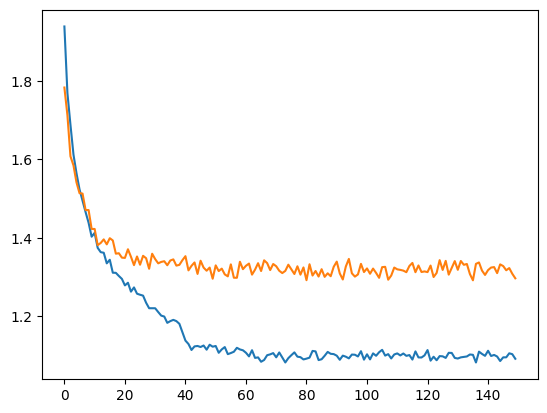

Accuracy: 0.5607


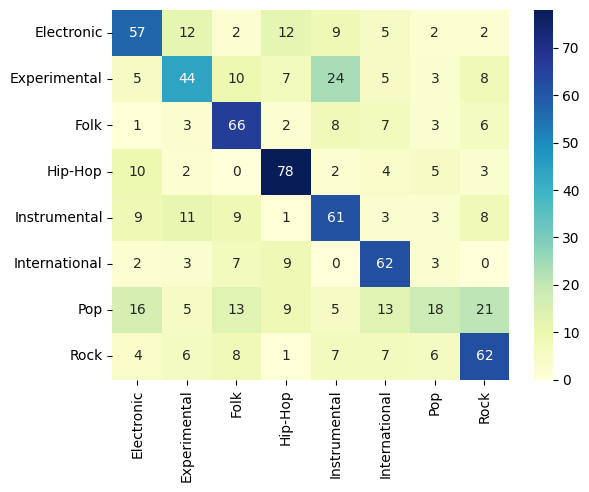

In [ ]:
cnn.load_state_dict(torch.load('best_model_lin.ckpt'))
#cnn.eval()
y_true = []
y_pred = []

for specs, labels in test_loader:
    with torch.no_grad():
        logits = cnn(specs.to(device))

    loss = loss_fn(logits, labels.to(device))
    losses.append(loss.item())
    _, pred = torch.max(logits.data, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

l = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=l, yticklabels=l, cmap='YlGnBu', fmt='d')
print('Accuracy: %.4f' % accuracy)

Lets try to make it better by spliting the the spectograms to 8 equal parts and train on these, then at test time the label is the majority vote of these parts. Testing both MusiCNN like architecture and a 1-d Convulational architecture.

In [6]:
def split_tensor_into_eight(tensor):
    l, f, t = tensor.shape

    if t % 8 != 0:
        raise ValueError("Time dimension must be divisible by 8.")

    new_tensor = torch.zeros(l * 8, f, t // 8)

    for i in range(l):
        for j in range(8):
            start_index = j * (t // 8)
            end_index = (j + 1) * (t // 8)
            new_tensor[i * 8 + j] = tensor[i, :, start_index:end_index]

    return new_tensor

In [ ]:
class Conv2d_layer(nn.Module):
    def __init__(self, out_c, kernel_size, pooling, dropout=0.1, padding = 'valid'):
        super(Conv2d_layer, self).__init__()
        self.layer = nn.Sequential(
            nn.LazyConv2d(out_c, kernel_size, padding = padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_c),
            nn.MaxPool2d(pooling, stride = pooling),
            nn.Dropout(dropout)
        )

    def forward(self, data):
        return self.layer(data)

class CNN(nn.Module):
    def __init__(self, n_chan, n_genres):
        super(CNN, self).__init__()

        self.inbn = nn.BatchNorm2d(1)

        self.convnet1 = nn.Sequential(
            Conv2d_layer(4 * n_chan, (52, 7), pooling = (1, 160), padding = 'same'),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.convnet2 = nn.Sequential(
            Conv2d_layer(4 * n_chan, (1, 32), pooling = (1, 129)),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.convnet3 = nn.Sequential(
            Conv2d_layer(2 * n_chan, (1, 128), pooling = (1, 33)),
        )

        self.convnet4 = nn.Sequential(
            nn.LazyConv1d(4 * n_chan, kernel_size = 7, padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm1d(4 * n_chan)
        )

        self.maxpool = nn.MaxPool1d(kernel_size = 112)
        self.avgpool = nn.AvgPool1d(kernel_size = 112)

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(),
            nn.LazyLinear(n_genres)
        )


    def forward(self, spec, hidden = None):
        spec = spec.unsqueeze(1)
        spec = self.inbn(spec)

        intdm = torch.cat((self.convnet1(spec).squeeze(), self.convnet2(spec).squeeze(), self.convnet3(spec).squeeze()), dim = 1)
        intdm = torch.permute(torch.cat((intdm, self.convnet4(intdm)), dim = 1), [0, 2, 1])

        intdm = torch.cat((self.avgpool(intdm), self.avgpool(intdm)), dim = 1)
        return self.linear(intdm)

In [ ]:
cnn = CNN(n_chan = 8, n_genres = 8).to(device)

# Send a sample to the net init all the lazy layers
t = cnn(split_tensor_into_eight(train_spec).to(device))
del t

n_epochs = 250
lr = 0.001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnn.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    losses = []

    for specs, labels in tqdm.tqdm(train_loader):
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn(specs.to(device))
        loss = loss_fn(logits, torch.repeat_interleave(labels.to(device), 8))

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch + 1, n_epochs, train_loss))

    losses = []
    y_true = []
    y_pred = []

    y_true_full = []
    y_pred_full = []

    for specs, labels in tqdm.tqdm(valid_loader):
        with torch.no_grad():
            specs = split_tensor_into_eight(specs.to(device))
            logits = cnn(specs.to(device))

        _, pred_full = torch.max(logits.data, 1)

        y_true_full.extend(torch.repeat_interleave(labels, 8).tolist())
        y_pred_full.extend(pred_full.tolist())

        logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)
        loss = loss_fn(logits, labels.to(device))
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    val_loss = np.mean(losses)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f, Valid accuracy full: %.4f, current LR: %f' % (epoch+1,
                                                                                                                 n_epochs,
                                                                                                                 val_loss,
                                                                                                                 accuracy,
                                                                                                                 accuracy_score(y_true_full, y_pred_full),
                                                                                                                 scheduler.get_last_lr()[-1]
                                                                                                                 ))

    if np.argmin(val_losses) == epoch:
        print('New best model found!')
        torch.save(cnn.state_dict(), 'best_model_lin_specsplit.ckpt')

torch.save(cnn.state_dict(), 'final_model_lin_specsplit.ckpt')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 175/175 [01:24<00:00,  2.06it/s]


Epoch: [1/250], Train loss: 1.9311


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: [1/250], Valid loss: 1.7402, Valid accuracy: 0.3590, Valid accuracy full: 0.3215, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  1.99it/s]


Epoch: [2/250], Train loss: 1.7402


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [2/250], Valid loss: 1.6415, Valid accuracy: 0.4071, Valid accuracy full: 0.3648, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [3/250], Train loss: 1.6776


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [3/250], Valid loss: 1.5946, Valid accuracy: 0.4240, Valid accuracy full: 0.3866, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [4/250], Train loss: 1.6609


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


Epoch: [4/250], Valid loss: 1.5951, Valid accuracy: 0.4228, Valid accuracy full: 0.3845, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [5/250], Train loss: 1.6346


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [5/250], Valid loss: 1.5584, Valid accuracy: 0.4453, Valid accuracy full: 0.4020, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [6/250], Train loss: 1.6087


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [6/250], Valid loss: 1.5381, Valid accuracy: 0.4534, Valid accuracy full: 0.4024, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [7/250], Train loss: 1.6020


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [7/250], Valid loss: 1.5388, Valid accuracy: 0.4503, Valid accuracy full: 0.3988, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [8/250], Train loss: 1.5767


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [8/250], Valid loss: 1.5242, Valid accuracy: 0.4409, Valid accuracy full: 0.4048, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [9/250], Train loss: 1.5626


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [9/250], Valid loss: 1.4976, Valid accuracy: 0.4634, Valid accuracy full: 0.4178, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [10/250], Train loss: 1.5453


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch: [10/250], Valid loss: 1.4823, Valid accuracy: 0.4728, Valid accuracy full: 0.4290, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [11/250], Train loss: 1.5359


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [11/250], Valid loss: 1.4722, Valid accuracy: 0.4828, Valid accuracy full: 0.4300, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  1.99it/s]


Epoch: [12/250], Train loss: 1.5259


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [12/250], Valid loss: 1.4845, Valid accuracy: 0.4884, Valid accuracy full: 0.4344, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [13/250], Train loss: 1.5092


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [13/250], Valid loss: 1.4712, Valid accuracy: 0.4884, Valid accuracy full: 0.4342, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [14/250], Train loss: 1.4997


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Epoch: [14/250], Valid loss: 1.4507, Valid accuracy: 0.4878, Valid accuracy full: 0.4404, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [15/250], Train loss: 1.4904


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [15/250], Valid loss: 1.4792, Valid accuracy: 0.4697, Valid accuracy full: 0.4274, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [16/250], Train loss: 1.4827


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [16/250], Valid loss: 1.4222, Valid accuracy: 0.5041, Valid accuracy full: 0.4429, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [17/250], Train loss: 1.4648


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


Epoch: [17/250], Valid loss: 1.4007, Valid accuracy: 0.5034, Valid accuracy full: 0.4515, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [18/250], Train loss: 1.4612


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [18/250], Valid loss: 1.4159, Valid accuracy: 0.5003, Valid accuracy full: 0.4495, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [19/250], Train loss: 1.4448


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [19/250], Valid loss: 1.4026, Valid accuracy: 0.5091, Valid accuracy full: 0.4512, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [20/250], Train loss: 1.4386


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [20/250], Valid loss: 1.3921, Valid accuracy: 0.5103, Valid accuracy full: 0.4555, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [21/250], Train loss: 1.4296


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: [21/250], Valid loss: 1.3787, Valid accuracy: 0.5253, Valid accuracy full: 0.4626, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [22/250], Train loss: 1.4112


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch: [22/250], Valid loss: 1.3785, Valid accuracy: 0.5178, Valid accuracy full: 0.4573, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [23/250], Train loss: 1.4123


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [23/250], Valid loss: 1.3754, Valid accuracy: 0.5197, Valid accuracy full: 0.4576, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [24/250], Train loss: 1.3911


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [24/250], Valid loss: 1.3902, Valid accuracy: 0.5297, Valid accuracy full: 0.4579, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [25/250], Train loss: 1.3940


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [25/250], Valid loss: 1.3817, Valid accuracy: 0.5247, Valid accuracy full: 0.4620, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  1.99it/s]


Epoch: [26/250], Train loss: 1.3867


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


Epoch: [26/250], Valid loss: 1.3745, Valid accuracy: 0.5297, Valid accuracy full: 0.4568, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [27/250], Train loss: 1.3739


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [27/250], Valid loss: 1.3445, Valid accuracy: 0.5435, Valid accuracy full: 0.4712, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [28/250], Train loss: 1.3679


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch: [28/250], Valid loss: 1.3559, Valid accuracy: 0.5310, Valid accuracy full: 0.4651, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [29/250], Train loss: 1.3573


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [29/250], Valid loss: 1.3356, Valid accuracy: 0.5335, Valid accuracy full: 0.4698, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [30/250], Train loss: 1.3539


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [30/250], Valid loss: 1.3110, Valid accuracy: 0.5466, Valid accuracy full: 0.4757, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [31/250], Train loss: 1.3400


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [31/250], Valid loss: 1.3134, Valid accuracy: 0.5428, Valid accuracy full: 0.4766, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [32/250], Train loss: 1.3356


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [32/250], Valid loss: 1.3051, Valid accuracy: 0.5410, Valid accuracy full: 0.4766, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [33/250], Train loss: 1.3358


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [33/250], Valid loss: 1.3042, Valid accuracy: 0.5528, Valid accuracy full: 0.4804, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [34/250], Train loss: 1.3281


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [34/250], Valid loss: 1.3053, Valid accuracy: 0.5566, Valid accuracy full: 0.4819, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [35/250], Train loss: 1.3251


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Epoch: [35/250], Valid loss: 1.2900, Valid accuracy: 0.5641, Valid accuracy full: 0.4868, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [36/250], Train loss: 1.3203


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: [36/250], Valid loss: 1.2818, Valid accuracy: 0.5591, Valid accuracy full: 0.4869, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [37/250], Train loss: 1.3160


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [37/250], Valid loss: 1.3107, Valid accuracy: 0.5478, Valid accuracy full: 0.4787, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [38/250], Train loss: 1.3062


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [38/250], Valid loss: 1.2818, Valid accuracy: 0.5660, Valid accuracy full: 0.4866, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [39/250], Train loss: 1.2984


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: [39/250], Valid loss: 1.2862, Valid accuracy: 0.5629, Valid accuracy full: 0.4849, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [40/250], Train loss: 1.3041


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: [40/250], Valid loss: 1.3120, Valid accuracy: 0.5535, Valid accuracy full: 0.4705, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [41/250], Train loss: 1.2941


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [41/250], Valid loss: 1.2911, Valid accuracy: 0.5516, Valid accuracy full: 0.4820, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [42/250], Train loss: 1.2830


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [42/250], Valid loss: 1.2877, Valid accuracy: 0.5535, Valid accuracy full: 0.4836, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [43/250], Train loss: 1.2810


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch: [43/250], Valid loss: 1.2888, Valid accuracy: 0.5610, Valid accuracy full: 0.4794, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [44/250], Train loss: 1.2739


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch: [44/250], Valid loss: 1.2911, Valid accuracy: 0.5485, Valid accuracy full: 0.4787, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [45/250], Train loss: 1.2725


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [45/250], Valid loss: 1.2938, Valid accuracy: 0.5585, Valid accuracy full: 0.4806, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [46/250], Train loss: 1.2716


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [46/250], Valid loss: 1.2979, Valid accuracy: 0.5566, Valid accuracy full: 0.4815, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [47/250], Train loss: 1.2681


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [47/250], Valid loss: 1.2906, Valid accuracy: 0.5660, Valid accuracy full: 0.4827, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [48/250], Train loss: 1.2604


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [48/250], Valid loss: 1.2677, Valid accuracy: 0.5672, Valid accuracy full: 0.4845, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [49/250], Train loss: 1.2599


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [49/250], Valid loss: 1.2935, Valid accuracy: 0.5654, Valid accuracy full: 0.4851, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [50/250], Train loss: 1.2576


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [50/250], Valid loss: 1.2815, Valid accuracy: 0.5647, Valid accuracy full: 0.4783, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [51/250], Train loss: 1.2579


100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


Epoch: [51/250], Valid loss: 1.2651, Valid accuracy: 0.5666, Valid accuracy full: 0.4882, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [52/250], Train loss: 1.2511


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [52/250], Valid loss: 1.2692, Valid accuracy: 0.5747, Valid accuracy full: 0.4867, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [53/250], Train loss: 1.2473


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


Epoch: [53/250], Valid loss: 1.2627, Valid accuracy: 0.5660, Valid accuracy full: 0.4882, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [54/250], Train loss: 1.2400


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [54/250], Valid loss: 1.2548, Valid accuracy: 0.5791, Valid accuracy full: 0.4894, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [55/250], Train loss: 1.2353


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


Epoch: [55/250], Valid loss: 1.2701, Valid accuracy: 0.5772, Valid accuracy full: 0.4838, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [56/250], Train loss: 1.2372


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [56/250], Valid loss: 1.2930, Valid accuracy: 0.5578, Valid accuracy full: 0.4778, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [57/250], Train loss: 1.2293


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [57/250], Valid loss: 1.2591, Valid accuracy: 0.5679, Valid accuracy full: 0.4910, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [58/250], Train loss: 1.2193


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [58/250], Valid loss: 1.2583, Valid accuracy: 0.5697, Valid accuracy full: 0.4896, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [59/250], Train loss: 1.2161


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [59/250], Valid loss: 1.2543, Valid accuracy: 0.5716, Valid accuracy full: 0.4862, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [60/250], Train loss: 1.2207


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [60/250], Valid loss: 1.2809, Valid accuracy: 0.5647, Valid accuracy full: 0.4863, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [61/250], Train loss: 1.2275


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [61/250], Valid loss: 1.2578, Valid accuracy: 0.5760, Valid accuracy full: 0.4916, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [62/250], Train loss: 1.2184


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [62/250], Valid loss: 1.2619, Valid accuracy: 0.5779, Valid accuracy full: 0.4844, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [63/250], Train loss: 1.2104


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [63/250], Valid loss: 1.2408, Valid accuracy: 0.5779, Valid accuracy full: 0.4933, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [64/250], Train loss: 1.2053


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [64/250], Valid loss: 1.2543, Valid accuracy: 0.5710, Valid accuracy full: 0.4910, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [65/250], Train loss: 1.2069


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch: [65/250], Valid loss: 1.2533, Valid accuracy: 0.5741, Valid accuracy full: 0.4894, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [66/250], Train loss: 1.1991


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [66/250], Valid loss: 1.2366, Valid accuracy: 0.5741, Valid accuracy full: 0.4869, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [67/250], Train loss: 1.2025


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch: [67/250], Valid loss: 1.2460, Valid accuracy: 0.5772, Valid accuracy full: 0.4908, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [68/250], Train loss: 1.1933


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Epoch: [68/250], Valid loss: 1.2442, Valid accuracy: 0.5860, Valid accuracy full: 0.4904, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [69/250], Train loss: 1.1911


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [69/250], Valid loss: 1.2610, Valid accuracy: 0.5722, Valid accuracy full: 0.4801, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [70/250], Train loss: 1.1933


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: [70/250], Valid loss: 1.2446, Valid accuracy: 0.5772, Valid accuracy full: 0.4880, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [71/250], Train loss: 1.1885


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [71/250], Valid loss: 1.2324, Valid accuracy: 0.5916, Valid accuracy full: 0.4916, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [72/250], Train loss: 1.1829


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [72/250], Valid loss: 1.2434, Valid accuracy: 0.5741, Valid accuracy full: 0.4912, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [73/250], Train loss: 1.1850


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


Epoch: [73/250], Valid loss: 1.2472, Valid accuracy: 0.5760, Valid accuracy full: 0.4863, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [74/250], Train loss: 1.1871


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [74/250], Valid loss: 1.2311, Valid accuracy: 0.5860, Valid accuracy full: 0.4941, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [75/250], Train loss: 1.1811


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


Epoch: [75/250], Valid loss: 1.2444, Valid accuracy: 0.5679, Valid accuracy full: 0.4930, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [76/250], Train loss: 1.1722


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [76/250], Valid loss: 1.2335, Valid accuracy: 0.5841, Valid accuracy full: 0.4947, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [77/250], Train loss: 1.1771


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [77/250], Valid loss: 1.2269, Valid accuracy: 0.5910, Valid accuracy full: 0.4934, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [78/250], Train loss: 1.1707


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [78/250], Valid loss: 1.2472, Valid accuracy: 0.5779, Valid accuracy full: 0.4927, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [79/250], Train loss: 1.1791


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [79/250], Valid loss: 1.2302, Valid accuracy: 0.5885, Valid accuracy full: 0.4929, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [80/250], Train loss: 1.1788


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [80/250], Valid loss: 1.2369, Valid accuracy: 0.5785, Valid accuracy full: 0.4893, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [81/250], Train loss: 1.1642


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [81/250], Valid loss: 1.2466, Valid accuracy: 0.5735, Valid accuracy full: 0.4828, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [82/250], Train loss: 1.1660


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [82/250], Valid loss: 1.2581, Valid accuracy: 0.5810, Valid accuracy full: 0.4859, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [83/250], Train loss: 1.1597


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [83/250], Valid loss: 1.2688, Valid accuracy: 0.5660, Valid accuracy full: 0.4838, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [84/250], Train loss: 1.1645


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


Epoch: [84/250], Valid loss: 1.2396, Valid accuracy: 0.5772, Valid accuracy full: 0.4891, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [85/250], Train loss: 1.1614


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [85/250], Valid loss: 1.2216, Valid accuracy: 0.5891, Valid accuracy full: 0.5005, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [86/250], Train loss: 1.1643


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [86/250], Valid loss: 1.2633, Valid accuracy: 0.5797, Valid accuracy full: 0.4876, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [87/250], Train loss: 1.1583


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [87/250], Valid loss: 1.2534, Valid accuracy: 0.5697, Valid accuracy full: 0.4879, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [88/250], Train loss: 1.1560


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


Epoch: [88/250], Valid loss: 1.2412, Valid accuracy: 0.5904, Valid accuracy full: 0.4935, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [89/250], Train loss: 1.1527


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch: [89/250], Valid loss: 1.2340, Valid accuracy: 0.5854, Valid accuracy full: 0.4964, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [90/250], Train loss: 1.1453


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [90/250], Valid loss: 1.2458, Valid accuracy: 0.5735, Valid accuracy full: 0.4861, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [91/250], Train loss: 1.1470


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [91/250], Valid loss: 1.2232, Valid accuracy: 0.5941, Valid accuracy full: 0.4949, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [92/250], Train loss: 1.1449


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [92/250], Valid loss: 1.2407, Valid accuracy: 0.5904, Valid accuracy full: 0.5005, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [93/250], Train loss: 1.1387


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [93/250], Valid loss: 1.2221, Valid accuracy: 0.5760, Valid accuracy full: 0.4916, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [94/250], Train loss: 1.1436


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [94/250], Valid loss: 1.2492, Valid accuracy: 0.5810, Valid accuracy full: 0.4848, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [95/250], Train loss: 1.1525


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [95/250], Valid loss: 1.2470, Valid accuracy: 0.5760, Valid accuracy full: 0.4833, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [96/250], Train loss: 1.1363


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [96/250], Valid loss: 1.2431, Valid accuracy: 0.6004, Valid accuracy full: 0.4927, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [97/250], Train loss: 1.1443


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [97/250], Valid loss: 1.2119, Valid accuracy: 0.5904, Valid accuracy full: 0.4902, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [98/250], Train loss: 1.1433


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [98/250], Valid loss: 1.2378, Valid accuracy: 0.5910, Valid accuracy full: 0.4903, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [99/250], Train loss: 1.1361


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch: [99/250], Valid loss: 1.2412, Valid accuracy: 0.5916, Valid accuracy full: 0.4900, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [100/250], Train loss: 1.1365


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [100/250], Valid loss: 1.2303, Valid accuracy: 0.5785, Valid accuracy full: 0.4894, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [101/250], Train loss: 1.1451


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


Epoch: [101/250], Valid loss: 1.2313, Valid accuracy: 0.5891, Valid accuracy full: 0.4889, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [102/250], Train loss: 1.1320


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [102/250], Valid loss: 1.2261, Valid accuracy: 0.6004, Valid accuracy full: 0.4930, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [103/250], Train loss: 1.1240


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [103/250], Valid loss: 1.2405, Valid accuracy: 0.5816, Valid accuracy full: 0.4898, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [104/250], Train loss: 1.1303


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [104/250], Valid loss: 1.2177, Valid accuracy: 0.5860, Valid accuracy full: 0.4957, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [105/250], Train loss: 1.1315


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [105/250], Valid loss: 1.2345, Valid accuracy: 0.5879, Valid accuracy full: 0.4980, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [106/250], Train loss: 1.1212


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: [106/250], Valid loss: 1.2245, Valid accuracy: 0.5860, Valid accuracy full: 0.4914, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [107/250], Train loss: 1.1219


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [107/250], Valid loss: 1.2388, Valid accuracy: 0.5785, Valid accuracy full: 0.4925, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [108/250], Train loss: 1.1240


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


Epoch: [108/250], Valid loss: 1.2145, Valid accuracy: 0.5972, Valid accuracy full: 0.4972, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [109/250], Train loss: 1.1232


100%|██████████| 50/50 [00:10<00:00,  4.82it/s]


Epoch: [109/250], Valid loss: 1.2384, Valid accuracy: 0.5860, Valid accuracy full: 0.4894, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [110/250], Train loss: 1.1198


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [110/250], Valid loss: 1.2267, Valid accuracy: 0.5804, Valid accuracy full: 0.4916, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [111/250], Train loss: 1.1163


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [111/250], Valid loss: 1.2375, Valid accuracy: 0.5947, Valid accuracy full: 0.4907, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [112/250], Train loss: 1.1150


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [112/250], Valid loss: 1.2272, Valid accuracy: 0.5954, Valid accuracy full: 0.4986, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [113/250], Train loss: 1.1100


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [113/250], Valid loss: 1.2196, Valid accuracy: 0.5854, Valid accuracy full: 0.5007, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [114/250], Train loss: 1.1148


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [114/250], Valid loss: 1.2283, Valid accuracy: 0.5816, Valid accuracy full: 0.4934, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [115/250], Train loss: 1.1088


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: [115/250], Valid loss: 1.2398, Valid accuracy: 0.5891, Valid accuracy full: 0.4952, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [116/250], Train loss: 1.1095


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch: [116/250], Valid loss: 1.2196, Valid accuracy: 0.5816, Valid accuracy full: 0.4942, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [117/250], Train loss: 1.1101


100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


Epoch: [117/250], Valid loss: 1.2143, Valid accuracy: 0.5935, Valid accuracy full: 0.4983, current LR: 0.001000


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [118/250], Train loss: 1.1140


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


Epoch: [118/250], Valid loss: 1.2204, Valid accuracy: 0.5866, Valid accuracy full: 0.4986, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [119/250], Train loss: 1.0736


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [119/250], Valid loss: 1.2157, Valid accuracy: 0.5960, Valid accuracy full: 0.4966, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [120/250], Train loss: 1.0671


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [120/250], Valid loss: 1.2095, Valid accuracy: 0.5972, Valid accuracy full: 0.4996, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [121/250], Train loss: 1.0651


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [121/250], Valid loss: 1.2068, Valid accuracy: 0.6029, Valid accuracy full: 0.4989, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [122/250], Train loss: 1.0612


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: [122/250], Valid loss: 1.2112, Valid accuracy: 0.5997, Valid accuracy full: 0.5048, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [123/250], Train loss: 1.0614


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [123/250], Valid loss: 1.2196, Valid accuracy: 0.5935, Valid accuracy full: 0.4995, current LR: 0.000100


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [124/250], Train loss: 1.0560


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [124/250], Valid loss: 1.2026, Valid accuracy: 0.5879, Valid accuracy full: 0.4970, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [125/250], Train loss: 1.0609


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [125/250], Valid loss: 1.2146, Valid accuracy: 0.5922, Valid accuracy full: 0.4946, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [126/250], Train loss: 1.0532


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [126/250], Valid loss: 1.2143, Valid accuracy: 0.5897, Valid accuracy full: 0.4975, current LR: 0.000100


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [127/250], Train loss: 1.0594


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


Epoch: [127/250], Valid loss: 1.2158, Valid accuracy: 0.5872, Valid accuracy full: 0.5013, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [128/250], Train loss: 1.0617


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [128/250], Valid loss: 1.2063, Valid accuracy: 0.5941, Valid accuracy full: 0.4996, current LR: 0.000100


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [129/250], Train loss: 1.0456


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch: [129/250], Valid loss: 1.2028, Valid accuracy: 0.5929, Valid accuracy full: 0.5020, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [130/250], Train loss: 1.0587


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [130/250], Valid loss: 1.2178, Valid accuracy: 0.6023, Valid accuracy full: 0.5080, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [131/250], Train loss: 1.0491


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [131/250], Valid loss: 1.2066, Valid accuracy: 0.6060, Valid accuracy full: 0.5056, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [132/250], Train loss: 1.0599


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [132/250], Valid loss: 1.2028, Valid accuracy: 0.6035, Valid accuracy full: 0.5068, current LR: 0.000100


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [133/250], Train loss: 1.0536


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch: [133/250], Valid loss: 1.2055, Valid accuracy: 0.6010, Valid accuracy full: 0.5010, current LR: 0.000100


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [134/250], Train loss: 1.0523


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [134/250], Valid loss: 1.2077, Valid accuracy: 0.6010, Valid accuracy full: 0.5003, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  1.99it/s]


Epoch: [135/250], Train loss: 1.0526


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [135/250], Valid loss: 1.2083, Valid accuracy: 0.5966, Valid accuracy full: 0.5069, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [136/250], Train loss: 1.0501


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [136/250], Valid loss: 1.2132, Valid accuracy: 0.5954, Valid accuracy full: 0.4987, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [137/250], Train loss: 1.0526


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [137/250], Valid loss: 1.2083, Valid accuracy: 0.6041, Valid accuracy full: 0.4998, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [138/250], Train loss: 1.0523


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


Epoch: [138/250], Valid loss: 1.2100, Valid accuracy: 0.5997, Valid accuracy full: 0.4959, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [139/250], Train loss: 1.0465


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


Epoch: [139/250], Valid loss: 1.1971, Valid accuracy: 0.5954, Valid accuracy full: 0.5027, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [140/250], Train loss: 1.0540


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [140/250], Valid loss: 1.2003, Valid accuracy: 0.5904, Valid accuracy full: 0.5007, current LR: 0.000100


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [141/250], Train loss: 1.0533


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [141/250], Valid loss: 1.2077, Valid accuracy: 0.5910, Valid accuracy full: 0.5010, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [142/250], Train loss: 1.0469


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [142/250], Valid loss: 1.1971, Valid accuracy: 0.6091, Valid accuracy full: 0.4984, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [143/250], Train loss: 1.0521


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [143/250], Valid loss: 1.2114, Valid accuracy: 0.5954, Valid accuracy full: 0.4991, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [144/250], Train loss: 1.0459


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [144/250], Valid loss: 1.1977, Valid accuracy: 0.5960, Valid accuracy full: 0.4994, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [145/250], Train loss: 1.0504


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [145/250], Valid loss: 1.2086, Valid accuracy: 0.5991, Valid accuracy full: 0.5005, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [146/250], Train loss: 1.0479


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch: [146/250], Valid loss: 1.2071, Valid accuracy: 0.6066, Valid accuracy full: 0.5027, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [147/250], Train loss: 1.0487


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


Epoch: [147/250], Valid loss: 1.1969, Valid accuracy: 0.6029, Valid accuracy full: 0.5018, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [148/250], Train loss: 1.0479


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


Epoch: [148/250], Valid loss: 1.2148, Valid accuracy: 0.5979, Valid accuracy full: 0.5019, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [149/250], Train loss: 1.0462


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


Epoch: [149/250], Valid loss: 1.2057, Valid accuracy: 0.6016, Valid accuracy full: 0.5013, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [150/250], Train loss: 1.0487


100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch: [150/250], Valid loss: 1.2199, Valid accuracy: 0.5954, Valid accuracy full: 0.4960, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [151/250], Train loss: 1.0464


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Epoch: [151/250], Valid loss: 1.2147, Valid accuracy: 0.6029, Valid accuracy full: 0.5011, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [152/250], Train loss: 1.0547


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch: [152/250], Valid loss: 1.2161, Valid accuracy: 0.5885, Valid accuracy full: 0.5027, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [153/250], Train loss: 1.0435


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [153/250], Valid loss: 1.2157, Valid accuracy: 0.5979, Valid accuracy full: 0.5020, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [154/250], Train loss: 1.0498


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: [154/250], Valid loss: 1.2018, Valid accuracy: 0.6010, Valid accuracy full: 0.4988, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [155/250], Train loss: 1.0514


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [155/250], Valid loss: 1.2115, Valid accuracy: 0.5966, Valid accuracy full: 0.4965, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [156/250], Train loss: 1.0571


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch: [156/250], Valid loss: 1.2059, Valid accuracy: 0.6048, Valid accuracy full: 0.4938, current LR: 0.000100


100%|██████████| 175/175 [01:26<00:00,  2.01it/s]


Epoch: [157/250], Train loss: 1.0459


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


Epoch: [157/250], Valid loss: 1.2124, Valid accuracy: 0.5947, Valid accuracy full: 0.4964, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [158/250], Train loss: 1.0412


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [158/250], Valid loss: 1.2160, Valid accuracy: 0.5985, Valid accuracy full: 0.4989, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [159/250], Train loss: 1.0438


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


Epoch: [159/250], Valid loss: 1.2063, Valid accuracy: 0.5941, Valid accuracy full: 0.5020, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [160/250], Train loss: 1.0504


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [160/250], Valid loss: 1.2019, Valid accuracy: 0.5929, Valid accuracy full: 0.4997, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [161/250], Train loss: 1.0446


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch: [161/250], Valid loss: 1.2143, Valid accuracy: 0.5979, Valid accuracy full: 0.4995, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.00it/s]


Epoch: [162/250], Train loss: 1.0469


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [162/250], Valid loss: 1.2146, Valid accuracy: 0.5985, Valid accuracy full: 0.4978, current LR: 0.000100


100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


Epoch: [163/250], Train loss: 1.0420


100%|██████████| 50/50 [00:10<00:00,  4.82it/s]


Epoch: [163/250], Valid loss: 1.2157, Valid accuracy: 0.6010, Valid accuracy full: 0.5019, current LR: 0.000100


  3%|▎         | 6/175 [00:03<01:39,  1.70it/s]


KeyboardInterrupt: 

<ipython-input-9-3dd9a8af835e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load('best_model_lin_specsplit.ckpt'))
100%|██████████| 25/25 [00:0

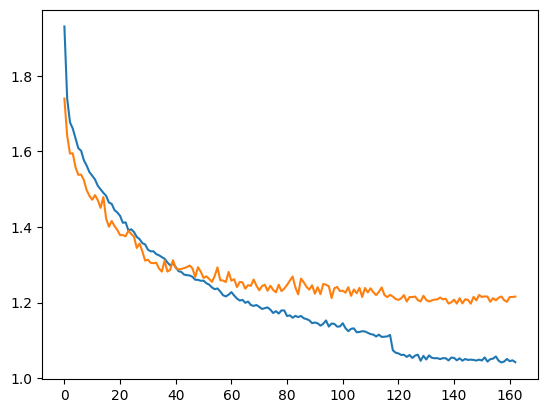

Accuracy: 0.6120


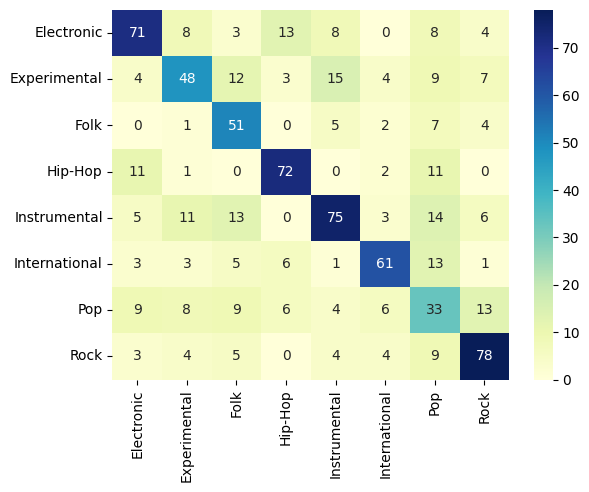

In [ ]:
#torch.save(cnn.state_dict(), 'final_model_lin_specsplit.ckpt')
cnn.load_state_dict(torch.load('best_model_lin_specsplit.ckpt'))

y_true = []
y_pred = []

for specs, labels in tqdm.tqdm(test_loader):
    with torch.no_grad():
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn(specs.to(device))

    logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)
    loss = loss_fn(logits, labels.to(device))
    losses.append(loss.item())
    _, pred = torch.max(logits.data, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

l = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=l, yticklabels=l, cmap='YlGnBu', fmt='d')
print('Accuracy: %.4f' % accuracy)

In [5]:
class Conv1d_layer(nn.Module):
    def __init__(self, out_c, kernel_size, pooling, dropout=0.1):
        super(Conv1d_layer, self).__init__()
        self.layer = nn.Sequential(
            nn.LazyConv1d(out_c, kernel_size, padding = kernel_size // 2),
            nn.BatchNorm1d(out_c),
            nn.ReLU(),
            nn.MaxPool1d(pooling, stride = pooling),
            nn.Dropout(dropout)
        )

    def forward(self, data):
        return self.layer(data)

class CNN_1DConv(nn.Module):
    def __init__(self, n_chan, kernel_size, n_genres):
        super(CNN_1DConv, self).__init__()

        self.convnet = nn.Sequential(
            nn.BatchNorm1d(n_chan),
            Conv1d_layer(n_chan * 3 // 4, kernel_size, pooling=4, dropout=0.25),
            Conv1d_layer(n_chan // 2, kernel_size, pooling=4, dropout=0.25),
            Conv1d_layer(n_chan // 2, kernel_size, pooling=4, dropout=0.25),
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(),
            nn.LazyLinear(n_genres)
        )

    def forward(self, spec, hidden = None):
        return self.linear(self.convnet(spec))

In [ ]:
cnn_conv = CNN_1DConv(n_chan = 128, kernel_size = 3, n_genres = 8).to(device)

# Send a sample to the net init all the lazy layers
t = cnn_conv(split_tensor_into_eight(train_spec).to(device))
del t

n_epochs = 250
lr = 0.001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnn_conv.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    losses = []

    for specs, labels in tqdm.tqdm(train_loader):
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn_conv(specs.to(device))
        loss = loss_fn(logits, torch.repeat_interleave(labels.to(device), 8))

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch + 1, n_epochs, train_loss))

    losses = []
    y_true = []
    y_pred = []

    y_true_full = []
    y_pred_full = []

    for specs, labels in tqdm.tqdm(valid_loader):
        with torch.no_grad():
            specs = split_tensor_into_eight(specs.to(device))
            logits = cnn_conv(specs.to(device))

        _, pred_full = torch.max(logits.data, 1)

        y_true_full.extend(torch.repeat_interleave(labels, 8).tolist())
        y_pred_full.extend(pred_full.tolist())

        logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)
        loss = loss_fn(logits, labels.to(device))
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    val_loss = np.mean(losses)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f, Valid accuracy full: %.4f, current LR: %f' % (epoch+1,
                                                                                                                 n_epochs,
                                                                                                                 val_loss,
                                                                                                                 accuracy,
                                                                                                                 accuracy_score(y_true_full, y_pred_full),
                                                                                                                 scheduler.get_last_lr()[-1]
                                                                                                                 ))

    if np.argmin(val_losses) == epoch:
        print('New best model found!')
        torch.save(cnn_conv.state_dict(), 'best_model_lin_specsplit1d.ckpt')

torch.save(cnn_conv.state_dict(), 'final_model_lin_specsplit1d.ckpt')


100%|██████████| 175/175 [00:09<00:00, 19.14it/s]


Epoch: [1/250], Train loss: 1.8098


100%|██████████| 50/50 [00:02<00:00, 23.44it/s]


Epoch: [1/250], Valid loss: 1.6568, Valid accuracy: 0.3859, Valid accuracy full: 0.3537, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.71it/s]


Epoch: [2/250], Train loss: 1.6997


100%|██████████| 50/50 [00:02<00:00, 23.36it/s]


Epoch: [2/250], Valid loss: 1.5853, Valid accuracy: 0.4265, Valid accuracy full: 0.3862, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.48it/s]


Epoch: [3/250], Train loss: 1.6595


100%|██████████| 50/50 [00:02<00:00, 23.80it/s]


Epoch: [3/250], Valid loss: 1.5569, Valid accuracy: 0.4484, Valid accuracy full: 0.4036, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.75it/s]


Epoch: [4/250], Train loss: 1.6100


100%|██████████| 50/50 [00:02<00:00, 21.97it/s]


Epoch: [4/250], Valid loss: 1.5215, Valid accuracy: 0.4534, Valid accuracy full: 0.4117, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 19.95it/s]


Epoch: [5/250], Train loss: 1.5967


100%|██████████| 50/50 [00:02<00:00, 20.67it/s]


Epoch: [5/250], Valid loss: 1.5041, Valid accuracy: 0.4878, Valid accuracy full: 0.4278, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 19.95it/s]


Epoch: [6/250], Train loss: 1.5627


100%|██████████| 50/50 [00:02<00:00, 23.18it/s]


Epoch: [6/250], Valid loss: 1.4655, Valid accuracy: 0.4891, Valid accuracy full: 0.4391, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.27it/s]


Epoch: [7/250], Train loss: 1.5448


100%|██████████| 50/50 [00:02<00:00, 23.40it/s]


Epoch: [7/250], Valid loss: 1.4698, Valid accuracy: 0.4903, Valid accuracy full: 0.4344, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.35it/s]


Epoch: [8/250], Train loss: 1.5334


100%|██████████| 50/50 [00:02<00:00, 23.94it/s]


Epoch: [8/250], Valid loss: 1.4509, Valid accuracy: 0.4884, Valid accuracy full: 0.4464, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.66it/s]


Epoch: [9/250], Train loss: 1.5049


100%|██████████| 50/50 [00:02<00:00, 23.08it/s]


Epoch: [9/250], Valid loss: 1.4131, Valid accuracy: 0.5122, Valid accuracy full: 0.4615, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 19.48it/s]


Epoch: [10/250], Train loss: 1.4945


100%|██████████| 50/50 [00:02<00:00, 19.72it/s]


Epoch: [10/250], Valid loss: 1.3986, Valid accuracy: 0.5103, Valid accuracy full: 0.4583, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 19.91it/s]


Epoch: [11/250], Train loss: 1.4795


100%|██████████| 50/50 [00:02<00:00, 22.89it/s]


Epoch: [11/250], Valid loss: 1.3920, Valid accuracy: 0.5103, Valid accuracy full: 0.4554, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.79it/s]


Epoch: [12/250], Train loss: 1.4628


100%|██████████| 50/50 [00:02<00:00, 23.05it/s]


Epoch: [12/250], Valid loss: 1.3689, Valid accuracy: 0.5203, Valid accuracy full: 0.4715, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.37it/s]


Epoch: [13/250], Train loss: 1.4544


100%|██████████| 50/50 [00:02<00:00, 24.19it/s]


Epoch: [13/250], Valid loss: 1.3801, Valid accuracy: 0.5310, Valid accuracy full: 0.4690, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.54it/s]


Epoch: [14/250], Train loss: 1.4448


100%|██████████| 50/50 [00:02<00:00, 23.32it/s]


Epoch: [14/250], Valid loss: 1.3680, Valid accuracy: 0.5241, Valid accuracy full: 0.4678, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 19.40it/s]


Epoch: [15/250], Train loss: 1.4433


100%|██████████| 50/50 [00:02<00:00, 19.00it/s]


Epoch: [15/250], Valid loss: 1.3413, Valid accuracy: 0.5360, Valid accuracy full: 0.4790, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 20.25it/s]


Epoch: [16/250], Train loss: 1.4186


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


Epoch: [16/250], Valid loss: 1.3128, Valid accuracy: 0.5472, Valid accuracy full: 0.4909, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.76it/s]


Epoch: [17/250], Train loss: 1.4189


100%|██████████| 50/50 [00:02<00:00, 23.87it/s]


Epoch: [17/250], Valid loss: 1.3457, Valid accuracy: 0.5297, Valid accuracy full: 0.4817, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.70it/s]


Epoch: [18/250], Train loss: 1.3999


100%|██████████| 50/50 [00:02<00:00, 24.08it/s]


Epoch: [18/250], Valid loss: 1.3212, Valid accuracy: 0.5347, Valid accuracy full: 0.4880, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.76it/s]


Epoch: [19/250], Train loss: 1.3882


100%|██████████| 50/50 [00:02<00:00, 22.49it/s]


Epoch: [19/250], Valid loss: 1.3216, Valid accuracy: 0.5391, Valid accuracy full: 0.4804, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.34it/s]


Epoch: [20/250], Train loss: 1.3700


100%|██████████| 50/50 [00:02<00:00, 21.17it/s]


Epoch: [20/250], Valid loss: 1.3312, Valid accuracy: 0.5366, Valid accuracy full: 0.4868, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.55it/s]


Epoch: [21/250], Train loss: 1.3770


100%|██████████| 50/50 [00:02<00:00, 19.98it/s]


Epoch: [21/250], Valid loss: 1.3045, Valid accuracy: 0.5453, Valid accuracy full: 0.4964, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 19.36it/s]


Epoch: [22/250], Train loss: 1.3624


100%|██████████| 50/50 [00:02<00:00, 24.92it/s]


Epoch: [22/250], Valid loss: 1.3048, Valid accuracy: 0.5535, Valid accuracy full: 0.4937, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.64it/s]


Epoch: [23/250], Train loss: 1.3554


100%|██████████| 50/50 [00:02<00:00, 24.81it/s]


Epoch: [23/250], Valid loss: 1.2623, Valid accuracy: 0.5641, Valid accuracy full: 0.5070, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.60it/s]


Epoch: [24/250], Train loss: 1.3525


100%|██████████| 50/50 [00:02<00:00, 23.68it/s]


Epoch: [24/250], Valid loss: 1.2606, Valid accuracy: 0.5772, Valid accuracy full: 0.5041, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 19.09it/s]


Epoch: [25/250], Train loss: 1.3463


100%|██████████| 50/50 [00:02<00:00, 22.12it/s]


Epoch: [25/250], Valid loss: 1.2498, Valid accuracy: 0.5810, Valid accuracy full: 0.5106, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 20.25it/s]


Epoch: [26/250], Train loss: 1.3277


100%|██████████| 50/50 [00:02<00:00, 20.55it/s]


Epoch: [26/250], Valid loss: 1.3029, Valid accuracy: 0.5441, Valid accuracy full: 0.4898, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.03it/s]


Epoch: [27/250], Train loss: 1.3186


100%|██████████| 50/50 [00:02<00:00, 24.32it/s]


Epoch: [27/250], Valid loss: 1.2403, Valid accuracy: 0.5791, Valid accuracy full: 0.5124, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.36it/s]


Epoch: [28/250], Train loss: 1.3273


100%|██████████| 50/50 [00:02<00:00, 23.06it/s]


Epoch: [28/250], Valid loss: 1.2400, Valid accuracy: 0.5810, Valid accuracy full: 0.5112, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.00it/s]


Epoch: [29/250], Train loss: 1.3163


100%|██████████| 50/50 [00:02<00:00, 24.53it/s]


Epoch: [29/250], Valid loss: 1.2630, Valid accuracy: 0.5810, Valid accuracy full: 0.5091, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.81it/s]


Epoch: [30/250], Train loss: 1.2982


100%|██████████| 50/50 [00:02<00:00, 23.95it/s]


Epoch: [30/250], Valid loss: 1.2608, Valid accuracy: 0.5735, Valid accuracy full: 0.5120, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.88it/s]


Epoch: [31/250], Train loss: 1.3064


100%|██████████| 50/50 [00:02<00:00, 20.79it/s]


Epoch: [31/250], Valid loss: 1.2632, Valid accuracy: 0.5785, Valid accuracy full: 0.5077, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.90it/s]


Epoch: [32/250], Train loss: 1.2925


100%|██████████| 50/50 [00:02<00:00, 22.54it/s]


Epoch: [32/250], Valid loss: 1.2185, Valid accuracy: 0.5816, Valid accuracy full: 0.5181, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.96it/s]


Epoch: [33/250], Train loss: 1.2789


100%|██████████| 50/50 [00:02<00:00, 24.43it/s]


Epoch: [33/250], Valid loss: 1.2628, Valid accuracy: 0.5635, Valid accuracy full: 0.5050, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.49it/s]


Epoch: [34/250], Train loss: 1.2825


100%|██████████| 50/50 [00:02<00:00, 24.82it/s]


Epoch: [34/250], Valid loss: 1.2174, Valid accuracy: 0.5897, Valid accuracy full: 0.5235, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.71it/s]


Epoch: [35/250], Train loss: 1.2823


100%|██████████| 50/50 [00:02<00:00, 24.63it/s]


Epoch: [35/250], Valid loss: 1.2257, Valid accuracy: 0.5922, Valid accuracy full: 0.5187, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.42it/s]


Epoch: [36/250], Train loss: 1.2801


100%|██████████| 50/50 [00:02<00:00, 19.25it/s]


Epoch: [36/250], Valid loss: 1.2418, Valid accuracy: 0.5722, Valid accuracy full: 0.5178, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.06it/s]


Epoch: [37/250], Train loss: 1.2751


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


Epoch: [37/250], Valid loss: 1.2345, Valid accuracy: 0.5910, Valid accuracy full: 0.5203, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.04it/s]


Epoch: [38/250], Train loss: 1.2656


100%|██████████| 50/50 [00:02<00:00, 24.08it/s]


Epoch: [38/250], Valid loss: 1.2549, Valid accuracy: 0.5729, Valid accuracy full: 0.5086, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.68it/s]


Epoch: [39/250], Train loss: 1.2537


100%|██████████| 50/50 [00:02<00:00, 23.24it/s]


Epoch: [39/250], Valid loss: 1.2112, Valid accuracy: 0.5860, Valid accuracy full: 0.5196, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.49it/s]


Epoch: [40/250], Train loss: 1.2551


100%|██████████| 50/50 [00:02<00:00, 23.91it/s]


Epoch: [40/250], Valid loss: 1.2370, Valid accuracy: 0.5872, Valid accuracy full: 0.5198, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.47it/s]


Epoch: [41/250], Train loss: 1.2536


100%|██████████| 50/50 [00:02<00:00, 20.03it/s]


Epoch: [41/250], Valid loss: 1.2209, Valid accuracy: 0.5822, Valid accuracy full: 0.5189, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.32it/s]


Epoch: [42/250], Train loss: 1.2422


100%|██████████| 50/50 [00:02<00:00, 22.01it/s]


Epoch: [42/250], Valid loss: 1.2227, Valid accuracy: 0.5816, Valid accuracy full: 0.5160, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.00it/s]


Epoch: [43/250], Train loss: 1.2343


100%|██████████| 50/50 [00:02<00:00, 24.57it/s]


Epoch: [43/250], Valid loss: 1.1978, Valid accuracy: 0.5947, Valid accuracy full: 0.5224, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.98it/s]


Epoch: [44/250], Train loss: 1.2286


100%|██████████| 50/50 [00:02<00:00, 24.15it/s]


Epoch: [44/250], Valid loss: 1.2452, Valid accuracy: 0.5685, Valid accuracy full: 0.5109, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.93it/s]


Epoch: [45/250], Train loss: 1.2299


100%|██████████| 50/50 [00:02<00:00, 24.46it/s]


Epoch: [45/250], Valid loss: 1.2374, Valid accuracy: 0.5860, Valid accuracy full: 0.5161, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.69it/s]


Epoch: [46/250], Train loss: 1.2207


100%|██████████| 50/50 [00:02<00:00, 19.97it/s]


Epoch: [46/250], Valid loss: 1.1945, Valid accuracy: 0.5985, Valid accuracy full: 0.5252, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 20.05it/s]


Epoch: [47/250], Train loss: 1.2246


100%|██████████| 50/50 [00:02<00:00, 21.48it/s]


Epoch: [47/250], Valid loss: 1.1941, Valid accuracy: 0.5972, Valid accuracy full: 0.5229, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.91it/s]


Epoch: [48/250], Train loss: 1.2095


100%|██████████| 50/50 [00:02<00:00, 23.34it/s]


Epoch: [48/250], Valid loss: 1.2033, Valid accuracy: 0.5804, Valid accuracy full: 0.5206, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.32it/s]


Epoch: [49/250], Train loss: 1.2164


100%|██████████| 50/50 [00:02<00:00, 23.44it/s]


Epoch: [49/250], Valid loss: 1.2198, Valid accuracy: 0.5747, Valid accuracy full: 0.5113, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.44it/s]


Epoch: [50/250], Train loss: 1.2128


100%|██████████| 50/50 [00:02<00:00, 22.53it/s]


Epoch: [50/250], Valid loss: 1.1962, Valid accuracy: 0.5910, Valid accuracy full: 0.5176, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.26it/s]


Epoch: [51/250], Train loss: 1.1974


100%|██████████| 50/50 [00:02<00:00, 20.30it/s]


Epoch: [51/250], Valid loss: 1.2353, Valid accuracy: 0.5779, Valid accuracy full: 0.5134, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.99it/s]


Epoch: [52/250], Train loss: 1.2082


100%|██████████| 50/50 [00:02<00:00, 22.27it/s]


Epoch: [52/250], Valid loss: 1.1896, Valid accuracy: 0.5966, Valid accuracy full: 0.5263, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.63it/s]


Epoch: [53/250], Train loss: 1.1860


100%|██████████| 50/50 [00:02<00:00, 24.43it/s]


Epoch: [53/250], Valid loss: 1.2101, Valid accuracy: 0.5829, Valid accuracy full: 0.5197, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.70it/s]


Epoch: [54/250], Train loss: 1.1932


100%|██████████| 50/50 [00:02<00:00, 24.83it/s]


Epoch: [54/250], Valid loss: 1.2084, Valid accuracy: 0.5916, Valid accuracy full: 0.5192, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.11it/s]


Epoch: [55/250], Train loss: 1.1873


100%|██████████| 50/50 [00:02<00:00, 22.67it/s]


Epoch: [55/250], Valid loss: 1.1998, Valid accuracy: 0.5891, Valid accuracy full: 0.5165, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.37it/s]


Epoch: [56/250], Train loss: 1.1822


100%|██████████| 50/50 [00:02<00:00, 19.86it/s]


Epoch: [56/250], Valid loss: 1.2063, Valid accuracy: 0.5879, Valid accuracy full: 0.5247, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.18it/s]


Epoch: [57/250], Train loss: 1.1765


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


Epoch: [57/250], Valid loss: 1.2267, Valid accuracy: 0.5785, Valid accuracy full: 0.5155, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.63it/s]


Epoch: [58/250], Train loss: 1.1818


100%|██████████| 50/50 [00:02<00:00, 24.15it/s]


Epoch: [58/250], Valid loss: 1.2100, Valid accuracy: 0.5829, Valid accuracy full: 0.5192, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.51it/s]


Epoch: [59/250], Train loss: 1.1663


100%|██████████| 50/50 [00:02<00:00, 23.29it/s]


Epoch: [59/250], Valid loss: 1.1819, Valid accuracy: 0.6054, Valid accuracy full: 0.5280, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.77it/s]


Epoch: [60/250], Train loss: 1.1865


100%|██████████| 50/50 [00:02<00:00, 22.87it/s]


Epoch: [60/250], Valid loss: 1.2015, Valid accuracy: 0.5891, Valid accuracy full: 0.5202, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.57it/s]


Epoch: [61/250], Train loss: 1.1677


100%|██████████| 50/50 [00:02<00:00, 19.99it/s]


Epoch: [61/250], Valid loss: 1.1687, Valid accuracy: 0.5947, Valid accuracy full: 0.5305, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 19.76it/s]


Epoch: [62/250], Train loss: 1.1527


100%|██████████| 50/50 [00:02<00:00, 21.07it/s]


Epoch: [62/250], Valid loss: 1.1756, Valid accuracy: 0.5997, Valid accuracy full: 0.5320, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 17.93it/s]


Epoch: [63/250], Train loss: 1.1636


100%|██████████| 50/50 [00:02<00:00, 22.33it/s]


Epoch: [63/250], Valid loss: 1.1871, Valid accuracy: 0.5929, Valid accuracy full: 0.5239, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.62it/s]


Epoch: [64/250], Train loss: 1.1532


100%|██████████| 50/50 [00:02<00:00, 24.65it/s]


Epoch: [64/250], Valid loss: 1.1990, Valid accuracy: 0.5835, Valid accuracy full: 0.5221, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.27it/s]


Epoch: [65/250], Train loss: 1.1546


100%|██████████| 50/50 [00:02<00:00, 23.68it/s]


Epoch: [65/250], Valid loss: 1.1892, Valid accuracy: 0.5916, Valid accuracy full: 0.5157, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.68it/s]


Epoch: [66/250], Train loss: 1.1502


100%|██████████| 50/50 [00:02<00:00, 20.88it/s]


Epoch: [66/250], Valid loss: 1.1974, Valid accuracy: 0.5966, Valid accuracy full: 0.5210, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.07it/s]


Epoch: [67/250], Train loss: 1.1512


100%|██████████| 50/50 [00:02<00:00, 20.72it/s]


Epoch: [67/250], Valid loss: 1.1819, Valid accuracy: 0.5979, Valid accuracy full: 0.5299, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.29it/s]


Epoch: [68/250], Train loss: 1.1454


100%|██████████| 50/50 [00:02<00:00, 23.50it/s]


Epoch: [68/250], Valid loss: 1.1748, Valid accuracy: 0.6023, Valid accuracy full: 0.5231, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.65it/s]


Epoch: [69/250], Train loss: 1.1395


100%|██████████| 50/50 [00:02<00:00, 24.39it/s]


Epoch: [69/250], Valid loss: 1.1698, Valid accuracy: 0.6048, Valid accuracy full: 0.5267, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.51it/s]


Epoch: [70/250], Train loss: 1.1361


100%|██████████| 50/50 [00:02<00:00, 23.47it/s]


Epoch: [70/250], Valid loss: 1.1804, Valid accuracy: 0.5991, Valid accuracy full: 0.5283, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.55it/s]


Epoch: [71/250], Train loss: 1.1233


100%|██████████| 50/50 [00:02<00:00, 22.61it/s]


Epoch: [71/250], Valid loss: 1.1932, Valid accuracy: 0.5966, Valid accuracy full: 0.5145, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.64it/s]


Epoch: [72/250], Train loss: 1.1221


100%|██████████| 50/50 [00:02<00:00, 19.38it/s]


Epoch: [72/250], Valid loss: 1.1841, Valid accuracy: 0.5979, Valid accuracy full: 0.5250, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.75it/s]


Epoch: [73/250], Train loss: 1.1223


100%|██████████| 50/50 [00:02<00:00, 23.30it/s]


Epoch: [73/250], Valid loss: 1.1951, Valid accuracy: 0.5997, Valid accuracy full: 0.5200, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.06it/s]


Epoch: [74/250], Train loss: 1.1279


100%|██████████| 50/50 [00:02<00:00, 23.78it/s]


Epoch: [74/250], Valid loss: 1.1824, Valid accuracy: 0.5960, Valid accuracy full: 0.5207, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.40it/s]


Epoch: [75/250], Train loss: 1.1262


100%|██████████| 50/50 [00:02<00:00, 24.10it/s]


Epoch: [75/250], Valid loss: 1.1751, Valid accuracy: 0.6035, Valid accuracy full: 0.5256, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.53it/s]


Epoch: [76/250], Train loss: 1.1285


100%|██████████| 50/50 [00:02<00:00, 23.15it/s]


Epoch: [76/250], Valid loss: 1.1894, Valid accuracy: 0.5872, Valid accuracy full: 0.5188, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.25it/s]


Epoch: [77/250], Train loss: 1.1088


100%|██████████| 50/50 [00:02<00:00, 19.86it/s]


Epoch: [77/250], Valid loss: 1.1694, Valid accuracy: 0.6029, Valid accuracy full: 0.5287, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.30it/s]


Epoch: [78/250], Train loss: 1.1158


100%|██████████| 50/50 [00:02<00:00, 21.31it/s]


Epoch: [78/250], Valid loss: 1.1778, Valid accuracy: 0.6035, Valid accuracy full: 0.5256, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.93it/s]


Epoch: [79/250], Train loss: 1.1153


100%|██████████| 50/50 [00:02<00:00, 23.47it/s]


Epoch: [79/250], Valid loss: 1.1743, Valid accuracy: 0.6041, Valid accuracy full: 0.5213, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.29it/s]


Epoch: [80/250], Train loss: 1.1061


100%|██████████| 50/50 [00:02<00:00, 24.15it/s]


Epoch: [80/250], Valid loss: 1.1810, Valid accuracy: 0.5960, Valid accuracy full: 0.5193, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.42it/s]


Epoch: [81/250], Train loss: 1.0983


100%|██████████| 50/50 [00:02<00:00, 24.15it/s]


Epoch: [81/250], Valid loss: 1.1686, Valid accuracy: 0.6035, Valid accuracy full: 0.5256, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.55it/s]


Epoch: [82/250], Train loss: 1.1106


100%|██████████| 50/50 [00:02<00:00, 20.49it/s]


Epoch: [82/250], Valid loss: 1.1822, Valid accuracy: 0.5891, Valid accuracy full: 0.5228, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 19.92it/s]


Epoch: [83/250], Train loss: 1.0594


100%|██████████| 50/50 [00:02<00:00, 20.82it/s]


Epoch: [83/250], Valid loss: 1.1460, Valid accuracy: 0.6048, Valid accuracy full: 0.5306, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [00:09<00:00, 19.13it/s]


Epoch: [84/250], Train loss: 1.0348


100%|██████████| 50/50 [00:01<00:00, 25.13it/s]


Epoch: [84/250], Valid loss: 1.1325, Valid accuracy: 0.6098, Valid accuracy full: 0.5347, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.32it/s]


Epoch: [85/250], Train loss: 1.0372


100%|██████████| 50/50 [00:02<00:00, 23.23it/s]


Epoch: [85/250], Valid loss: 1.1389, Valid accuracy: 0.6123, Valid accuracy full: 0.5378, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.17it/s]


Epoch: [86/250], Train loss: 1.0200


100%|██████████| 50/50 [00:02<00:00, 23.41it/s]


Epoch: [86/250], Valid loss: 1.1434, Valid accuracy: 0.6123, Valid accuracy full: 0.5338, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 19.26it/s]


Epoch: [87/250], Train loss: 1.0269


100%|██████████| 50/50 [00:02<00:00, 21.09it/s]


Epoch: [87/250], Valid loss: 1.1395, Valid accuracy: 0.6191, Valid accuracy full: 0.5372, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 20.29it/s]


Epoch: [88/250], Train loss: 1.0349


100%|██████████| 50/50 [00:02<00:00, 20.55it/s]


Epoch: [88/250], Valid loss: 1.1420, Valid accuracy: 0.6110, Valid accuracy full: 0.5379, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 19.24it/s]


Epoch: [89/250], Train loss: 1.0280


100%|██████████| 50/50 [00:02<00:00, 23.89it/s]


Epoch: [89/250], Valid loss: 1.1404, Valid accuracy: 0.6135, Valid accuracy full: 0.5351, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.29it/s]


Epoch: [90/250], Train loss: 1.0205


100%|██████████| 50/50 [00:02<00:00, 23.84it/s]


Epoch: [90/250], Valid loss: 1.1417, Valid accuracy: 0.6141, Valid accuracy full: 0.5312, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.31it/s]


Epoch: [91/250], Train loss: 1.0185


100%|██████████| 50/50 [00:02<00:00, 23.85it/s]


Epoch: [91/250], Valid loss: 1.1385, Valid accuracy: 0.6129, Valid accuracy full: 0.5353, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.66it/s]


Epoch: [92/250], Train loss: 1.0162


100%|██████████| 50/50 [00:02<00:00, 20.82it/s]


Epoch: [92/250], Valid loss: 1.1355, Valid accuracy: 0.6148, Valid accuracy full: 0.5349, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 20.20it/s]


Epoch: [93/250], Train loss: 1.0130


100%|██████████| 50/50 [00:02<00:00, 20.66it/s]


Epoch: [93/250], Valid loss: 1.1435, Valid accuracy: 0.6254, Valid accuracy full: 0.5389, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 19.51it/s]


Epoch: [94/250], Train loss: 1.0203


100%|██████████| 50/50 [00:02<00:00, 24.43it/s]


Epoch: [94/250], Valid loss: 1.1448, Valid accuracy: 0.6198, Valid accuracy full: 0.5310, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.42it/s]


Epoch: [95/250], Train loss: 1.0156


100%|██████████| 50/50 [00:02<00:00, 24.32it/s]


Epoch: [95/250], Valid loss: 1.1382, Valid accuracy: 0.6160, Valid accuracy full: 0.5349, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.50it/s]


Epoch: [96/250], Train loss: 1.0170


100%|██████████| 50/50 [00:02<00:00, 23.29it/s]


Epoch: [96/250], Valid loss: 1.1496, Valid accuracy: 0.6210, Valid accuracy full: 0.5343, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.82it/s]


Epoch: [97/250], Train loss: 1.0130


100%|██████████| 50/50 [00:02<00:00, 21.93it/s]


Epoch: [97/250], Valid loss: 1.1437, Valid accuracy: 0.6091, Valid accuracy full: 0.5385, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 20.04it/s]


Epoch: [98/250], Train loss: 1.0126


100%|██████████| 50/50 [00:02<00:00, 19.83it/s]


Epoch: [98/250], Valid loss: 1.1358, Valid accuracy: 0.6185, Valid accuracy full: 0.5388, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 19.21it/s]


Epoch: [99/250], Train loss: 1.0182


100%|██████████| 50/50 [00:02<00:00, 22.65it/s]


Epoch: [99/250], Valid loss: 1.1334, Valid accuracy: 0.6160, Valid accuracy full: 0.5346, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.28it/s]


Epoch: [100/250], Train loss: 1.0134


100%|██████████| 50/50 [00:02<00:00, 24.47it/s]


Epoch: [100/250], Valid loss: 1.1452, Valid accuracy: 0.6129, Valid accuracy full: 0.5325, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.61it/s]


Epoch: [101/250], Train loss: 1.0192


100%|██████████| 50/50 [00:02<00:00, 23.91it/s]


Epoch: [101/250], Valid loss: 1.1387, Valid accuracy: 0.6129, Valid accuracy full: 0.5339, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 19.56it/s]


Epoch: [102/250], Train loss: 1.0124


100%|██████████| 50/50 [00:02<00:00, 20.24it/s]


Epoch: [102/250], Valid loss: 1.1392, Valid accuracy: 0.6098, Valid accuracy full: 0.5303, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 20.27it/s]


Epoch: [103/250], Train loss: 1.0130


100%|██████████| 50/50 [00:02<00:00, 22.29it/s]


Epoch: [103/250], Valid loss: 1.1279, Valid accuracy: 0.6148, Valid accuracy full: 0.5338, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.91it/s]


Epoch: [104/250], Train loss: 1.0107


100%|██████████| 50/50 [00:02<00:00, 24.23it/s]


Epoch: [104/250], Valid loss: 1.1513, Valid accuracy: 0.6123, Valid accuracy full: 0.5269, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.33it/s]


Epoch: [105/250], Train loss: 1.0083


100%|██████████| 50/50 [00:02<00:00, 23.27it/s]


Epoch: [105/250], Valid loss: 1.1539, Valid accuracy: 0.6141, Valid accuracy full: 0.5316, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.07it/s]


Epoch: [106/250], Train loss: 1.0047


100%|██████████| 50/50 [00:02<00:00, 23.23it/s]


Epoch: [106/250], Valid loss: 1.1509, Valid accuracy: 0.6148, Valid accuracy full: 0.5300, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 19.42it/s]


Epoch: [107/250], Train loss: 1.0124


100%|██████████| 50/50 [00:02<00:00, 18.91it/s]


Epoch: [107/250], Valid loss: 1.1443, Valid accuracy: 0.6191, Valid accuracy full: 0.5313, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 19.97it/s]


Epoch: [108/250], Train loss: 1.0086


100%|██████████| 50/50 [00:02<00:00, 21.51it/s]


Epoch: [108/250], Valid loss: 1.1596, Valid accuracy: 0.6129, Valid accuracy full: 0.5324, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 19.00it/s]


Epoch: [109/250], Train loss: 1.0083


100%|██████████| 50/50 [00:02<00:00, 23.66it/s]


Epoch: [109/250], Valid loss: 1.1474, Valid accuracy: 0.6091, Valid accuracy full: 0.5326, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.33it/s]


Epoch: [110/250], Train loss: 1.0044


100%|██████████| 50/50 [00:02<00:00, 23.29it/s]


Epoch: [110/250], Valid loss: 1.1398, Valid accuracy: 0.6141, Valid accuracy full: 0.5318, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.28it/s]


Epoch: [111/250], Train loss: 1.0060


100%|██████████| 50/50 [00:02<00:00, 23.04it/s]


Epoch: [111/250], Valid loss: 1.1388, Valid accuracy: 0.6091, Valid accuracy full: 0.5318, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.85it/s]


Epoch: [112/250], Train loss: 1.0081


100%|██████████| 50/50 [00:02<00:00, 21.15it/s]


Epoch: [112/250], Valid loss: 1.1405, Valid accuracy: 0.6204, Valid accuracy full: 0.5347, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 19.80it/s]


Epoch: [113/250], Train loss: 1.0093


100%|██████████| 50/50 [00:02<00:00, 19.73it/s]


Epoch: [113/250], Valid loss: 1.1413, Valid accuracy: 0.6160, Valid accuracy full: 0.5303, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 19.00it/s]


Epoch: [114/250], Train loss: 1.0118


100%|██████████| 50/50 [00:02<00:00, 24.31it/s]


Epoch: [114/250], Valid loss: 1.1283, Valid accuracy: 0.6166, Valid accuracy full: 0.5299, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.14it/s]


Epoch: [115/250], Train loss: 1.0020


100%|██████████| 50/50 [00:02<00:00, 23.24it/s]


Epoch: [115/250], Valid loss: 1.1495, Valid accuracy: 0.6223, Valid accuracy full: 0.5303, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 17.99it/s]


Epoch: [116/250], Train loss: 1.0079


100%|██████████| 50/50 [00:02<00:00, 23.91it/s]


Epoch: [116/250], Valid loss: 1.1449, Valid accuracy: 0.6173, Valid accuracy full: 0.5303, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 17.80it/s]


Epoch: [117/250], Train loss: 1.0050


100%|██████████| 50/50 [00:02<00:00, 22.88it/s]


Epoch: [117/250], Valid loss: 1.1500, Valid accuracy: 0.6204, Valid accuracy full: 0.5297, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 19.34it/s]


Epoch: [118/250], Train loss: 1.0079


100%|██████████| 50/50 [00:02<00:00, 18.39it/s]


Epoch: [118/250], Valid loss: 1.1426, Valid accuracy: 0.6216, Valid accuracy full: 0.5320, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 19.87it/s]


Epoch: [119/250], Train loss: 1.0076


100%|██████████| 50/50 [00:02<00:00, 23.68it/s]


Epoch: [119/250], Valid loss: 1.1435, Valid accuracy: 0.6091, Valid accuracy full: 0.5320, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.45it/s]


Epoch: [120/250], Train loss: 1.0025


100%|██████████| 50/50 [00:02<00:00, 24.20it/s]


Epoch: [120/250], Valid loss: 1.1401, Valid accuracy: 0.6166, Valid accuracy full: 0.5350, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.25it/s]


Epoch: [121/250], Train loss: 1.0000


100%|██████████| 50/50 [00:02<00:00, 24.90it/s]


Epoch: [121/250], Valid loss: 1.1319, Valid accuracy: 0.6223, Valid accuracy full: 0.5348, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.20it/s]


Epoch: [122/250], Train loss: 1.0061


100%|██████████| 50/50 [00:02<00:00, 23.27it/s]


Epoch: [122/250], Valid loss: 1.1311, Valid accuracy: 0.6129, Valid accuracy full: 0.5323, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 19.31it/s]


Epoch: [123/250], Train loss: 1.0009


100%|██████████| 50/50 [00:02<00:00, 18.92it/s]


Epoch: [123/250], Valid loss: 1.1388, Valid accuracy: 0.6016, Valid accuracy full: 0.5351, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 19.37it/s]


Epoch: [124/250], Train loss: 1.0065


100%|██████████| 50/50 [00:02<00:00, 23.01it/s]


Epoch: [124/250], Valid loss: 1.1597, Valid accuracy: 0.6098, Valid accuracy full: 0.5291, current LR: 0.000010


100%|██████████| 175/175 [00:09<00:00, 18.43it/s]


Epoch: [125/250], Train loss: 0.9971


100%|██████████| 50/50 [00:02<00:00, 23.83it/s]


Epoch: [125/250], Valid loss: 1.1372, Valid accuracy: 0.6198, Valid accuracy full: 0.5293, current LR: 0.000010


100%|██████████| 175/175 [00:09<00:00, 18.05it/s]


Epoch: [126/250], Train loss: 0.9915


100%|██████████| 50/50 [00:02<00:00, 23.95it/s]


Epoch: [126/250], Valid loss: 1.1425, Valid accuracy: 0.6160, Valid accuracy full: 0.5326, current LR: 0.000010


100%|██████████| 175/175 [00:09<00:00, 18.54it/s]


Epoch: [127/250], Train loss: 0.9983


100%|██████████| 50/50 [00:02<00:00, 23.70it/s]


Epoch: [127/250], Valid loss: 1.1370, Valid accuracy: 0.6198, Valid accuracy full: 0.5328, current LR: 0.000010


100%|██████████| 175/175 [00:09<00:00, 19.24it/s]


Epoch: [128/250], Train loss: 0.9989


100%|██████████| 50/50 [00:02<00:00, 20.28it/s]


Epoch: [128/250], Valid loss: 1.1310, Valid accuracy: 0.6123, Valid accuracy full: 0.5321, current LR: 0.000010


100%|██████████| 175/175 [00:08<00:00, 19.69it/s]


Epoch: [129/250], Train loss: 0.9900


100%|██████████| 50/50 [00:02<00:00, 19.80it/s]


Epoch: [129/250], Valid loss: 1.1410, Valid accuracy: 0.6154, Valid accuracy full: 0.5377, current LR: 0.000010


100%|██████████| 175/175 [00:09<00:00, 18.89it/s]


Epoch: [130/250], Train loss: 0.9906


100%|██████████| 50/50 [00:02<00:00, 23.37it/s]


Epoch: [130/250], Valid loss: 1.1421, Valid accuracy: 0.6216, Valid accuracy full: 0.5348, current LR: 0.000010


100%|██████████| 175/175 [00:09<00:00, 18.03it/s]


Epoch: [131/250], Train loss: 0.9931


100%|██████████| 50/50 [00:02<00:00, 23.57it/s]


Epoch: [131/250], Valid loss: 1.1445, Valid accuracy: 0.6141, Valid accuracy full: 0.5336, current LR: 0.000010


100%|██████████| 175/175 [00:09<00:00, 17.91it/s]


Epoch: [132/250], Train loss: 0.9952


100%|██████████| 50/50 [00:02<00:00, 23.52it/s]


Epoch: [132/250], Valid loss: 1.1409, Valid accuracy: 0.6141, Valid accuracy full: 0.5281, current LR: 0.000010


100%|██████████| 175/175 [00:09<00:00, 18.70it/s]


Epoch: [133/250], Train loss: 0.9949


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


Epoch: [133/250], Valid loss: 1.1309, Valid accuracy: 0.6166, Valid accuracy full: 0.5329, current LR: 0.000010


100%|██████████| 175/175 [00:08<00:00, 19.87it/s]


Epoch: [134/250], Train loss: 0.9934


100%|██████████| 50/50 [00:02<00:00, 20.39it/s]


Epoch: [134/250], Valid loss: 1.1360, Valid accuracy: 0.6160, Valid accuracy full: 0.5367, current LR: 0.000010


 84%|████████▍ | 147/175 [00:07<00:01, 18.77it/s]


KeyboardInterrupt: 

<ipython-input-27-cf59c4870fb6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_conv.load_state_dict(torch.load('best_model_lin_specsplit1d.ckpt'))
100%|██████████| 25/

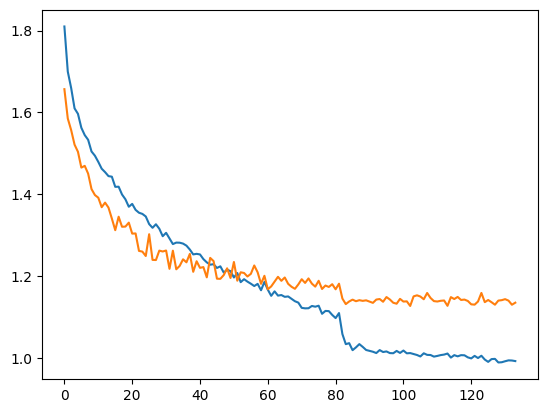

Accuracy: 0.6158


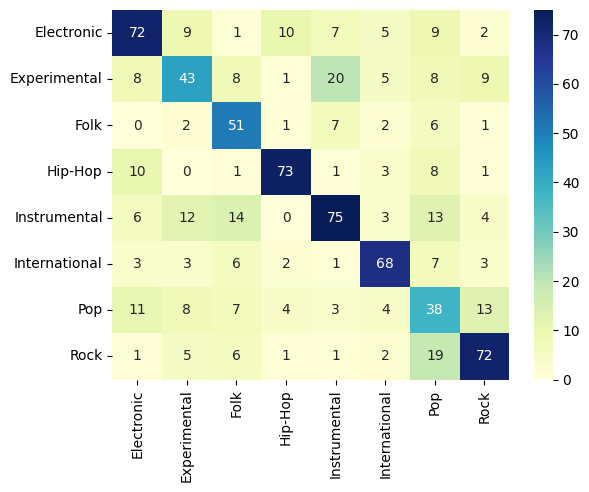

In [ ]:
#torch.save(cnn_conv.state_dict(), 'final_model_lin_specsplit1d.ckpt')
cnn_conv.load_state_dict(torch.load('best_model_lin_specsplit1d.ckpt'))

y_true = []
y_pred = []

for specs, labels in tqdm.tqdm(test_loader):
    with torch.no_grad():
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn_conv(specs.to(device))

    logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)

    _, pred = torch.max(logits.data, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

l = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=l, yticklabels=l, cmap='YlGnBu', fmt='d')
print('Accuracy: %.4f' % accuracy)